No GPU available, using the CPU instead.


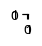

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

import torch
from torch import optim, nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'

In [369]:
','.join(ibel_sine.HLA.unique())

'HLA-A0101,HLA-A0201,HLA-A0205,HLA-A0301,HLA-A1101,HLA-A2402,HLA-A2601,HLA-A3001,HLA-A6801,HLA-B0702,HLA-B1801,HLA-B2705,HLA-B3501,HLA-B3503,HLA-B3801,HLA-B4001,HLA-B4002,HLA-B4403,HLA-B5101,HLA-C0304,HLA-C0401,HLA-C0602,HLA-C0701,HLA-C0702,HLA-B0801,HLA-B1302,HLA-B4402,HLA-B5701,HLA-C0501,HLA-A3101,HLA-B1501,HLA-A3002,HLA-B3701,HLA-C0102'

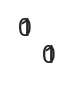

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

In [3]:
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]

# init

## reloading datasets

In [4]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')

In [5]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve

3480


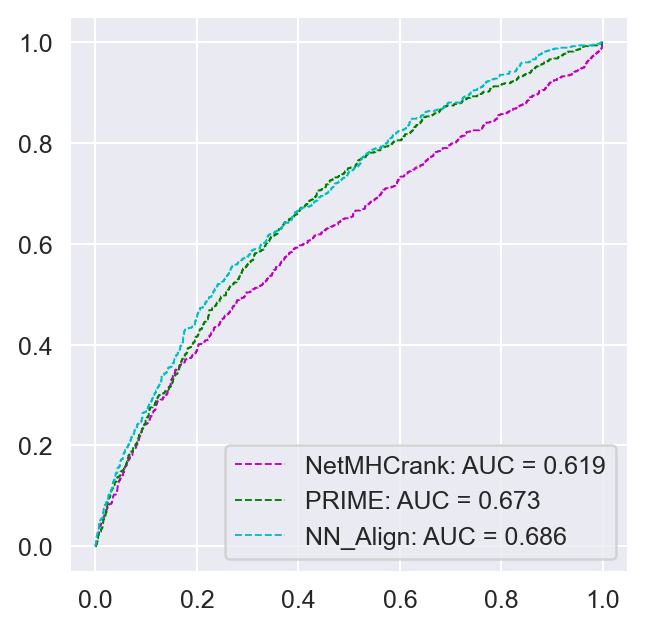

In [7]:
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)
a.legend()

In [8]:
from src.baselines import plot_related_baseline_roc

In [9]:
cpeps = cedar_related_baseline.Peptide.values
ppeps = prime_related_baseline.Peptide.values
cp_common_peps = [x for x in cpeps if x in ppeps]
len(ibel.query('Peptide not in @cpeps and Peptide not in @ppeps')), len(ibel)

(86, 94)

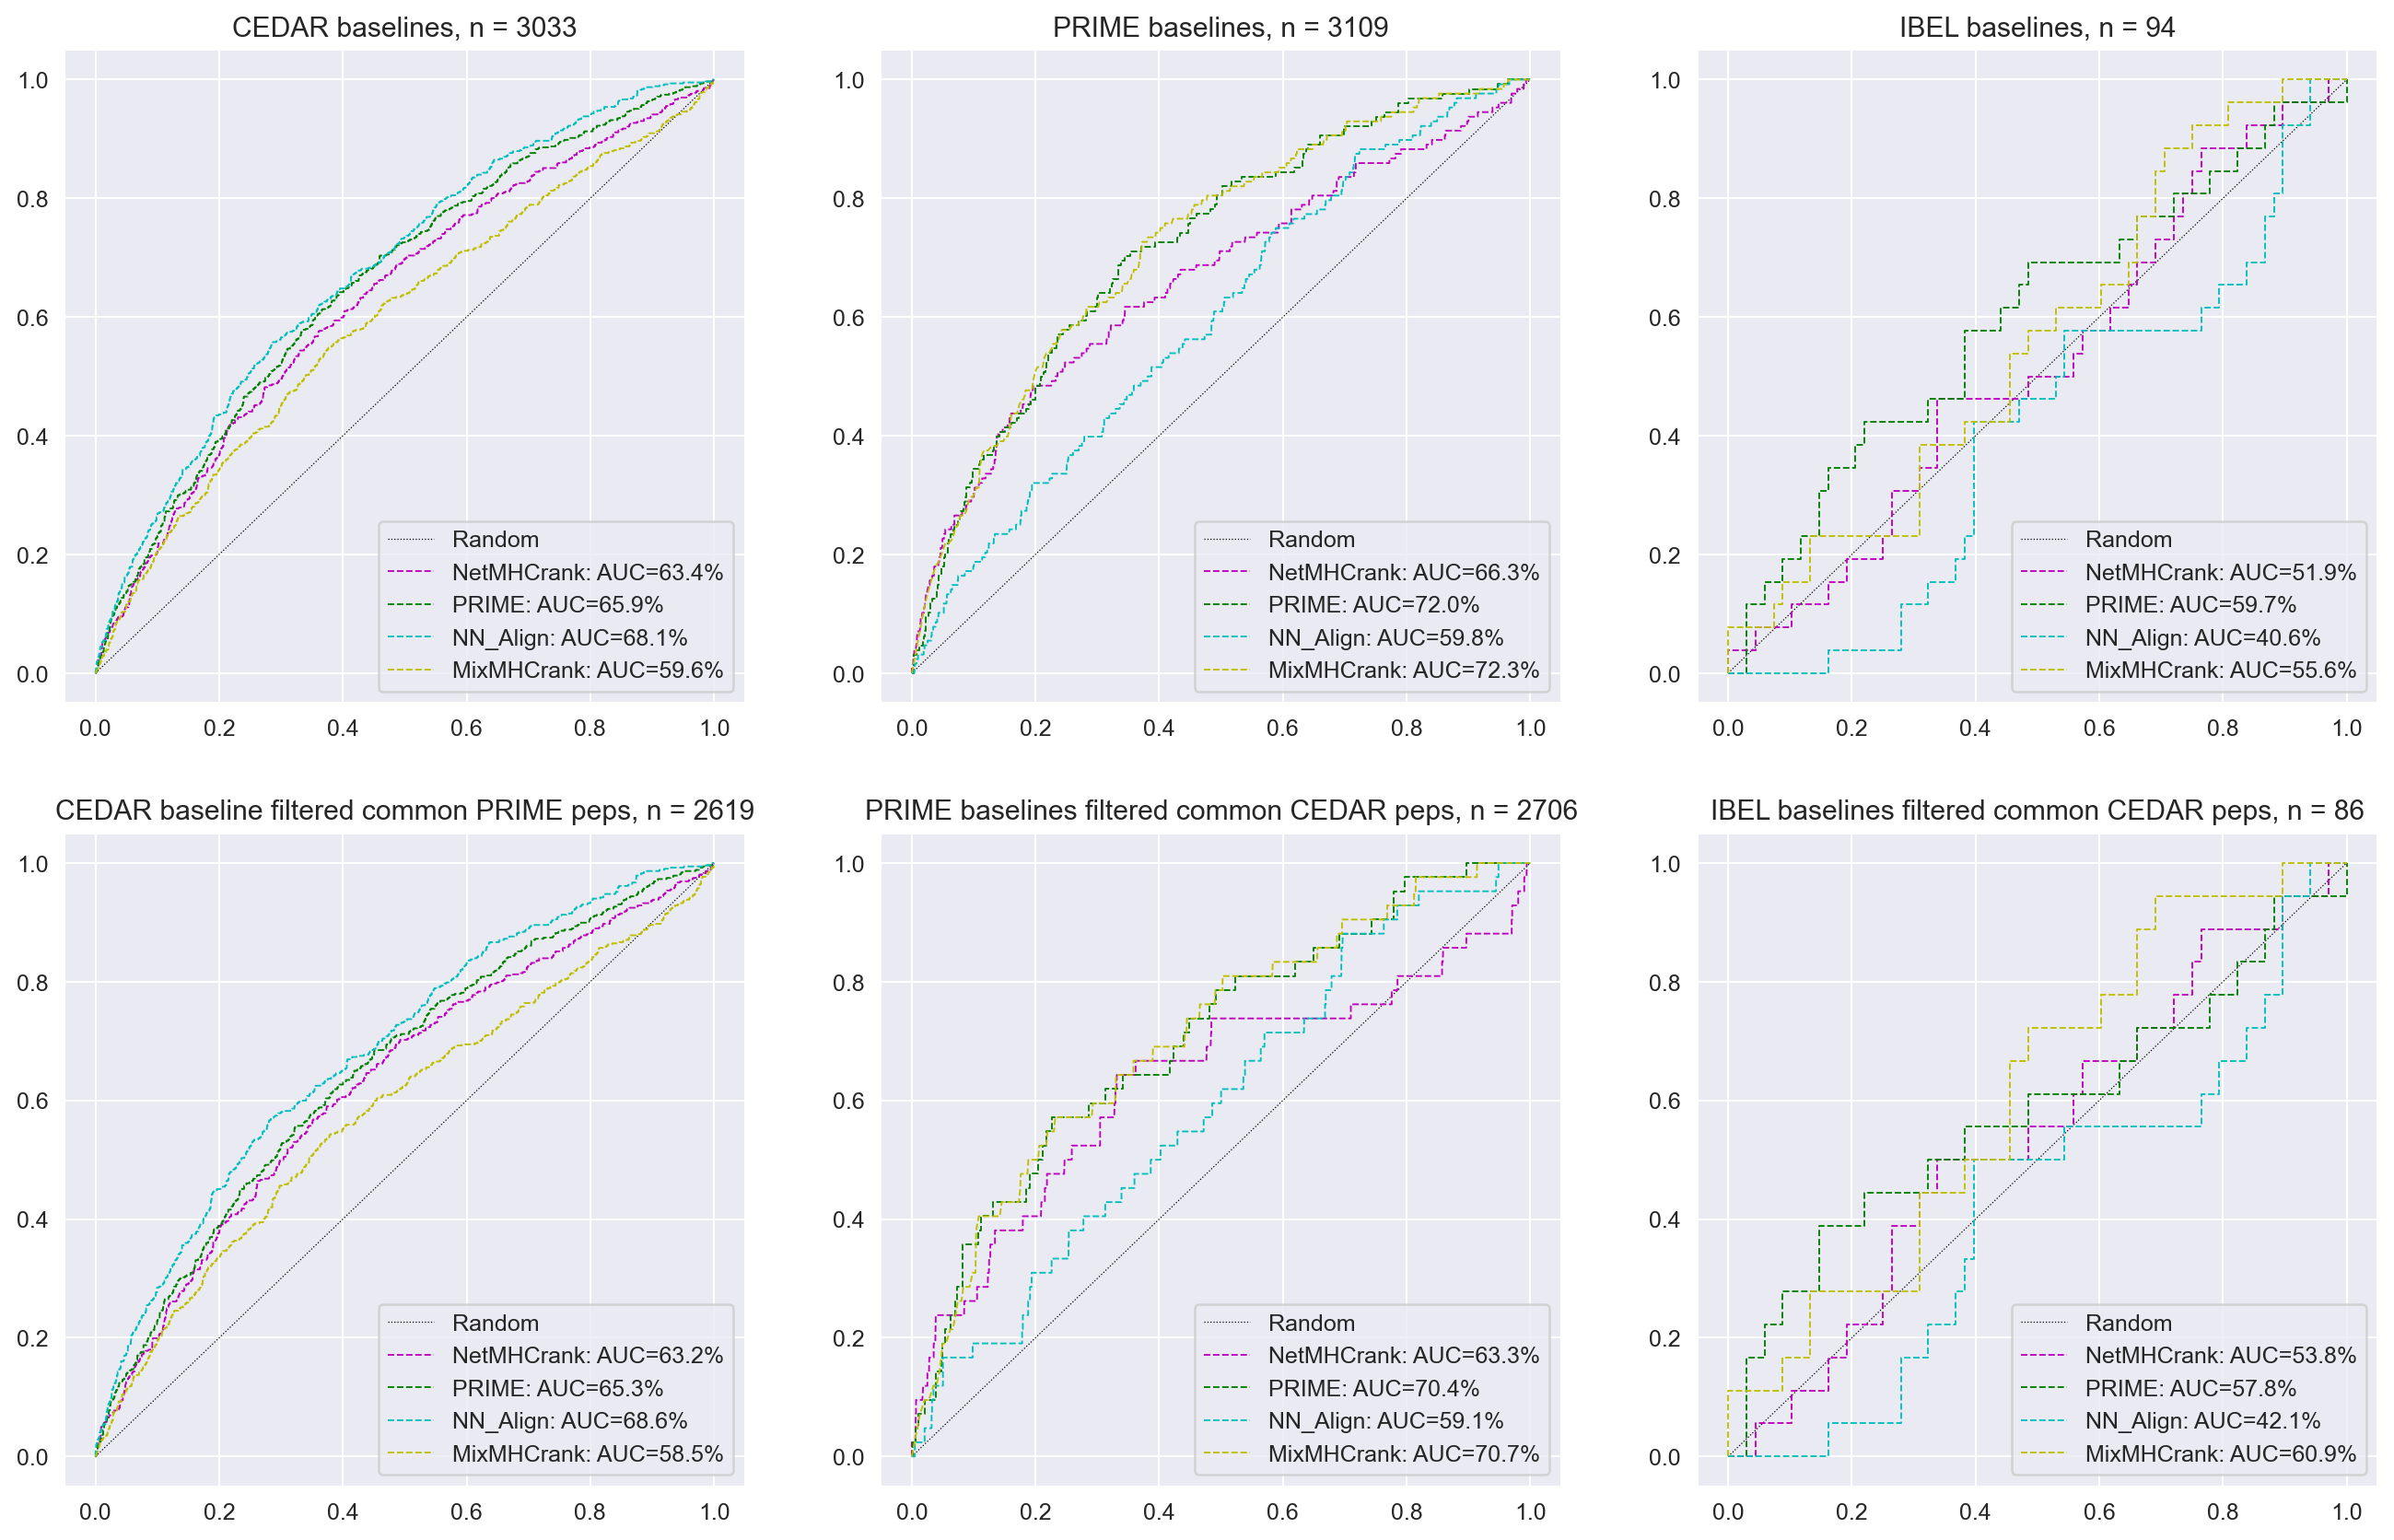

In [10]:
f,a = plt.subplots(2,3, figsize=(18,11.25))
a = a.ravel()
plot_related_baseline_roc(a[0], dataset=cedar_related_baseline)
plot_related_baseline_roc(a[1], dataset=prime_related_baseline)
plot_related_baseline_roc(a[2], dataset=ibel)

plot_related_baseline_roc(a[3], dataset=cedar_related_baseline.query('Peptide not in @ppeps'))
plot_related_baseline_roc(a[4], dataset=prime_related_baseline.query('Peptide not in @cpeps'))
plot_related_baseline_roc(a[5], dataset=ibel.query('Peptide not in @cpeps and Peptide not in @ppeps'))

a[0].set_title(f'CEDAR baselines, n = {len(cedar_related_baseline)}')
a[1].set_title(f'PRIME baselines, n = {len(prime_related_baseline)}')
a[2].set_title(f'IBEL baselines, n = {len(ibel)}')
a[3].set_title(f'CEDAR baseline filtered common PRIME peps, n = {len(cedar_related_baseline.query("Peptide not in @ppeps"))}')
a[4].set_title(f'PRIME baselines filtered common CEDAR peps, n = {len(prime_related_baseline.query("Peptide not in @cpeps"))}')
a[5].set_title(f'IBEL baselines filtered common CEDAR peps, n = {len(ibel.query("Peptide not in @cpeps and Peptide not in @ppeps"))}')

a[0].legend(loc = 'lower right')
a[1].legend(loc = 'lower right')
a[2].legend(loc = 'lower right')
a[3].legend(loc = 'lower right')
a[4].legend(loc = 'lower right')
a[5].legend(loc = 'lower right')

In [11]:
tmp = ibel.query('Peptide not in @cpeps and Peptide not in @ppeps')
roc_auc_score(tmp['agg_label'], tmp['PRIME_score'])

0.5784313725490196

In [351]:
cols = ['HLA', 'agg_label', 'Peptide', 'wild_type', 'Peptide_mut', 'Peptide_wt', 'icore_mut', 'icore_wt', 'core_wt', 'core_mut', 'EL_rank_mut', 'EL_rank_wt']

# Best models

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve

In [434]:
from scipy.stats import spearmanr, pearsonr

for k in best_models:
    print('##################\n\n',k)
    tmp = best_models[k]['cedar']
    tmp, aacols = get_aa_properties(tmp)
    for c in aacols+list(filter(lambda x: 'score' in x.lower(), tmp.columns)):
        r, pv= spearmanr(tmp[c].values , tmp['pred'].values)
        print(f'\t{c}\tR= {r:.4f},\tp= {pv:.3e}')
    print('\n##################\n\n')

##################

 Best for CEDAR
	aliphatic_index	R= 0.4678,	p= 8.188e-165
	boman	R= -0.4173,	p= 4.094e-128
	hydrophobicity	R= 0.4563,	p= 6.981e-156
	isoelectric_point	R= -0.1949,	p= 2.364e-27
	VHSE1	R= 0.5214,	p= 4.338e-211
	VHSE3	R= 0.3525,	p= 1.890e-89
	VHSE7	R= -0.1399,	p= 9.985e-15
	VHSE8	R= -0.3256,	p= 7.326e-76
	blsm_mut_score	R= -0.0411,	p= 2.366e-02
	core_blsm_mut_score	R= 0.0202,	p= 2.669e-01
	core_mutation_score	R= -0.0028,	p= 8.786e-01
	dissimilarity_score	R= -0.0035,	p= 8.466e-01
	mutation_score	R= 0.0140,	p= 4.424e-01

##################


##################

 Best for PRIME
	aliphatic_index	R= 0.2312,	p= 4.355e-38
	boman	R= -0.2494,	p= 3.166e-44
	hydrophobicity	R= 0.2441,	p= 2.176e-42
	isoelectric_point	R= -0.1010,	p= 2.491e-08
	VHSE1	R= 0.3515,	p= 6.661e-89
	VHSE3	R= 0.3287,	p= 2.316e-77
	VHSE7	R= -0.1358,	p= 5.956e-14
	VHSE8	R= -0.1632,	p= 1.531e-19
	blsm_mut_score	R= -0.0194,	p= 2.866e-01
	core_blsm_mut_score	R= 0.0096,	p= 5.990e-01
	core_mutation_score	R= -0.0305,

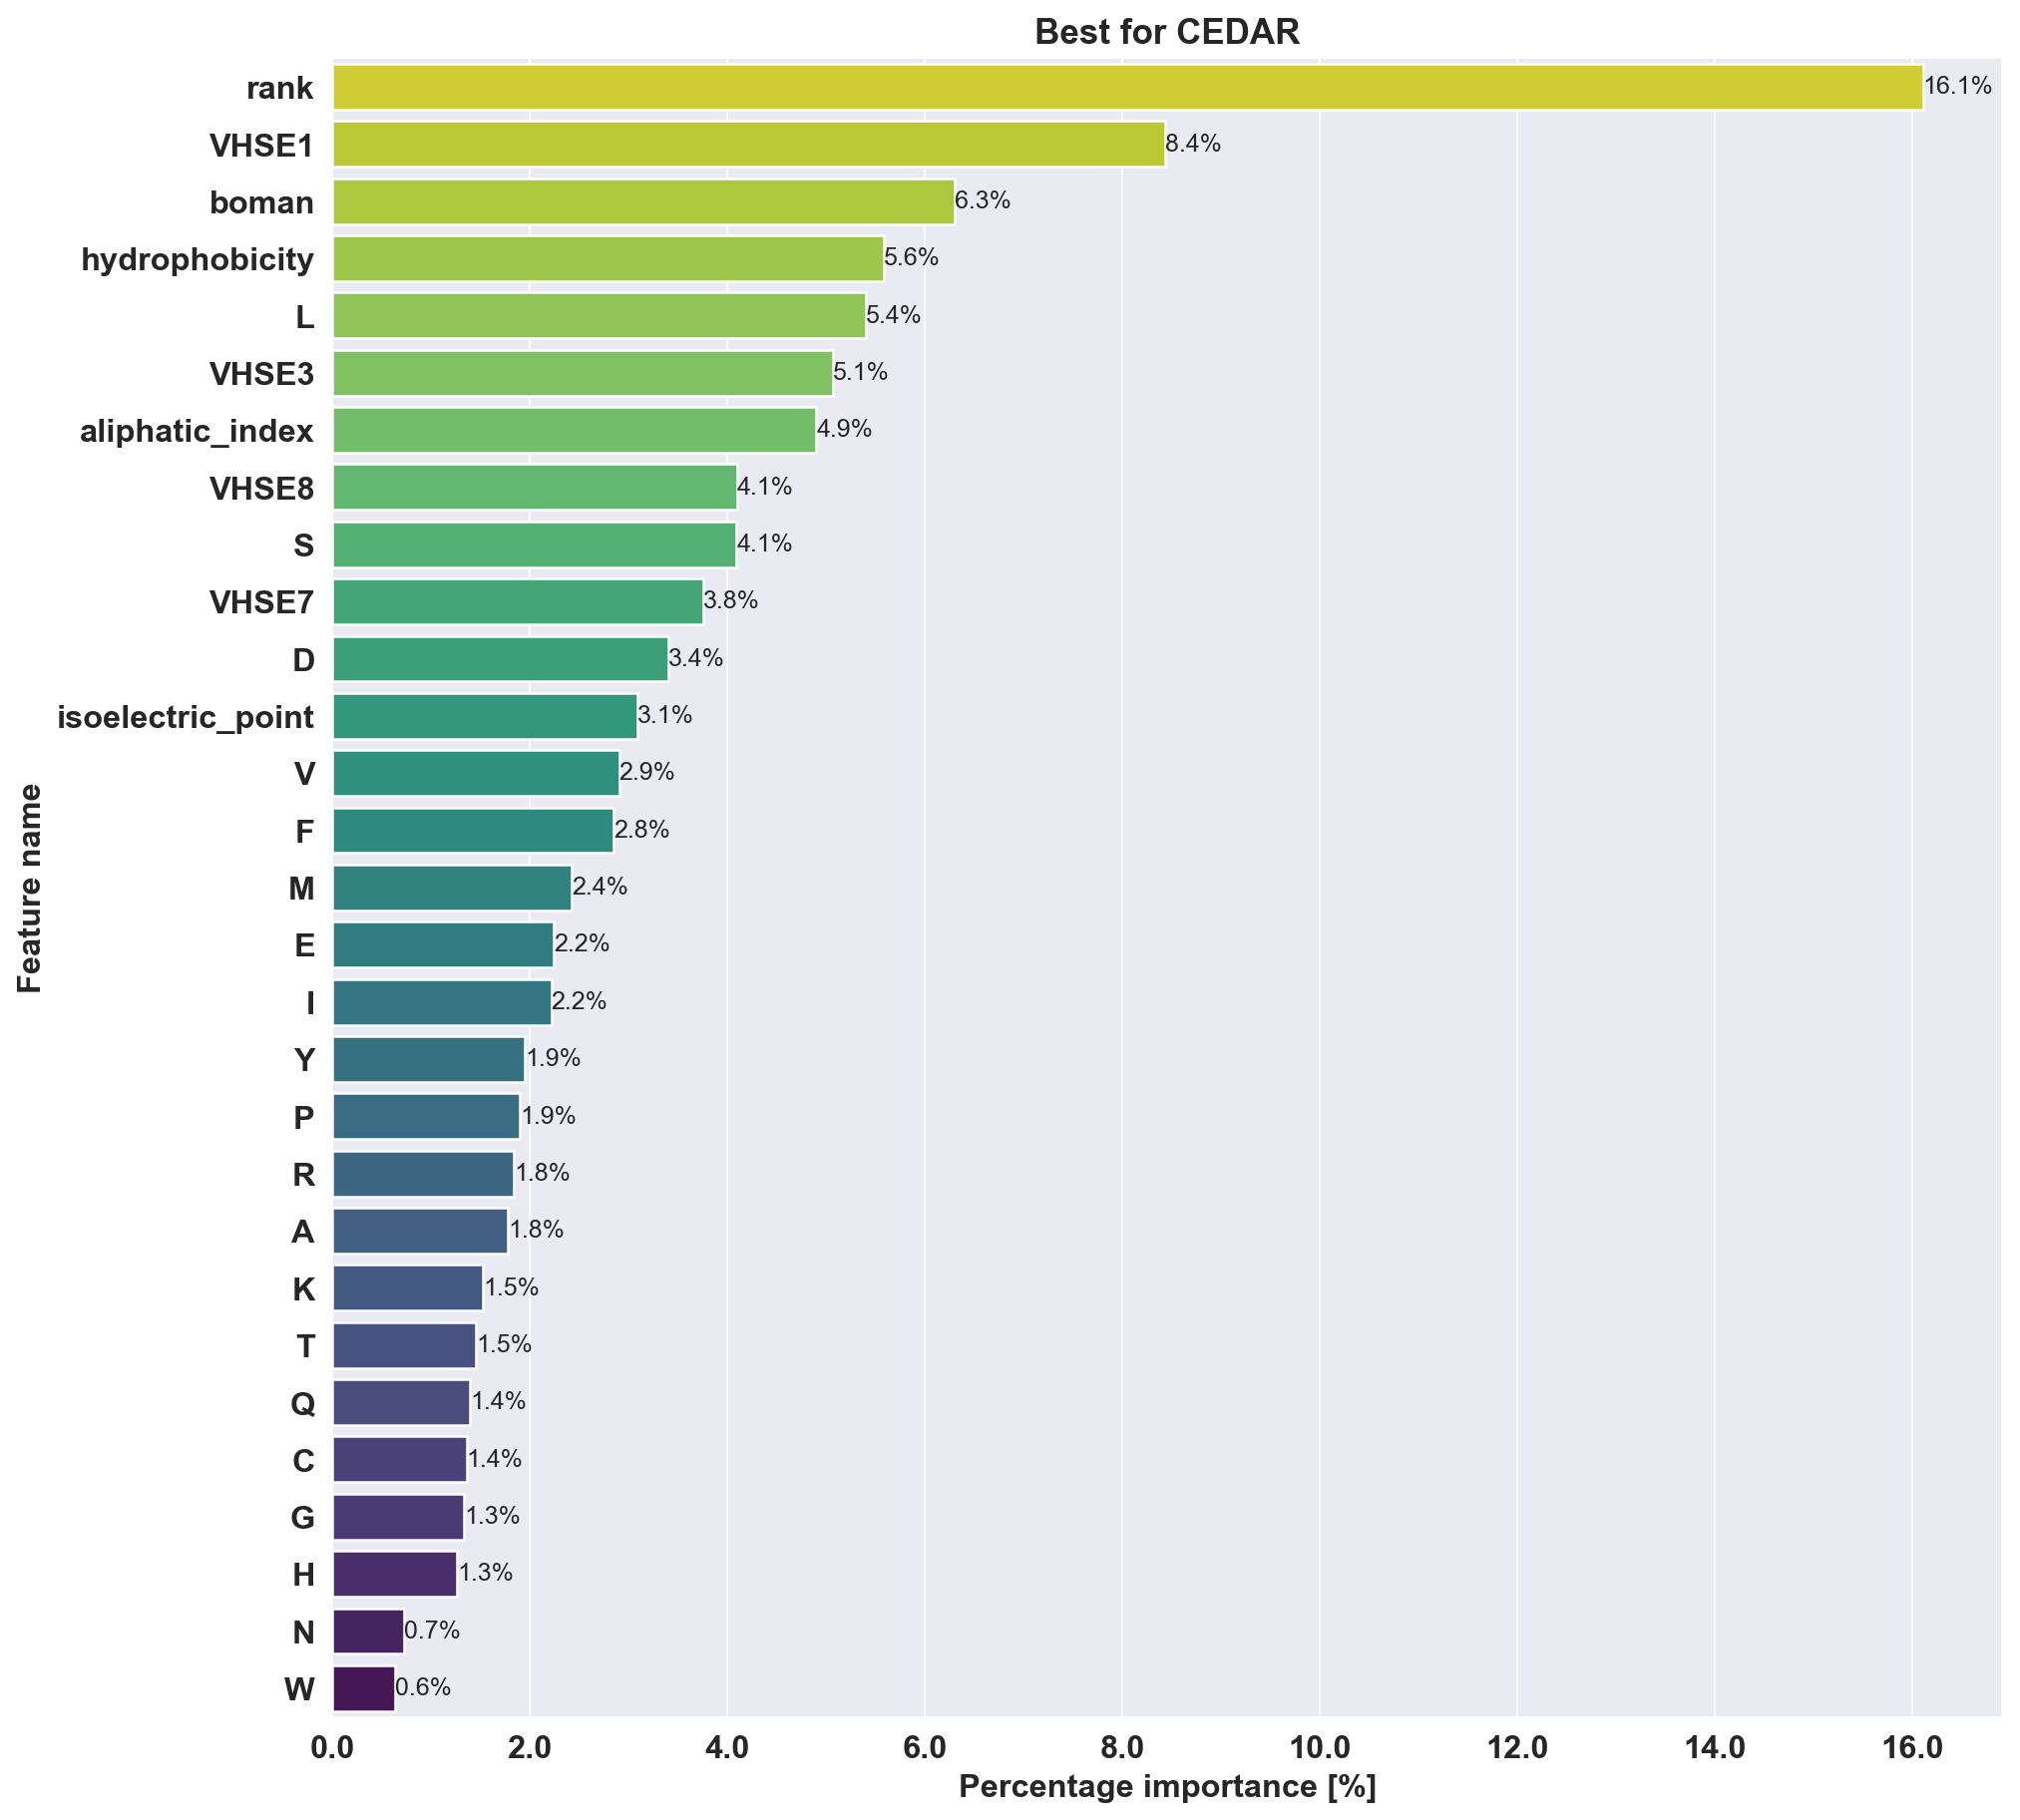

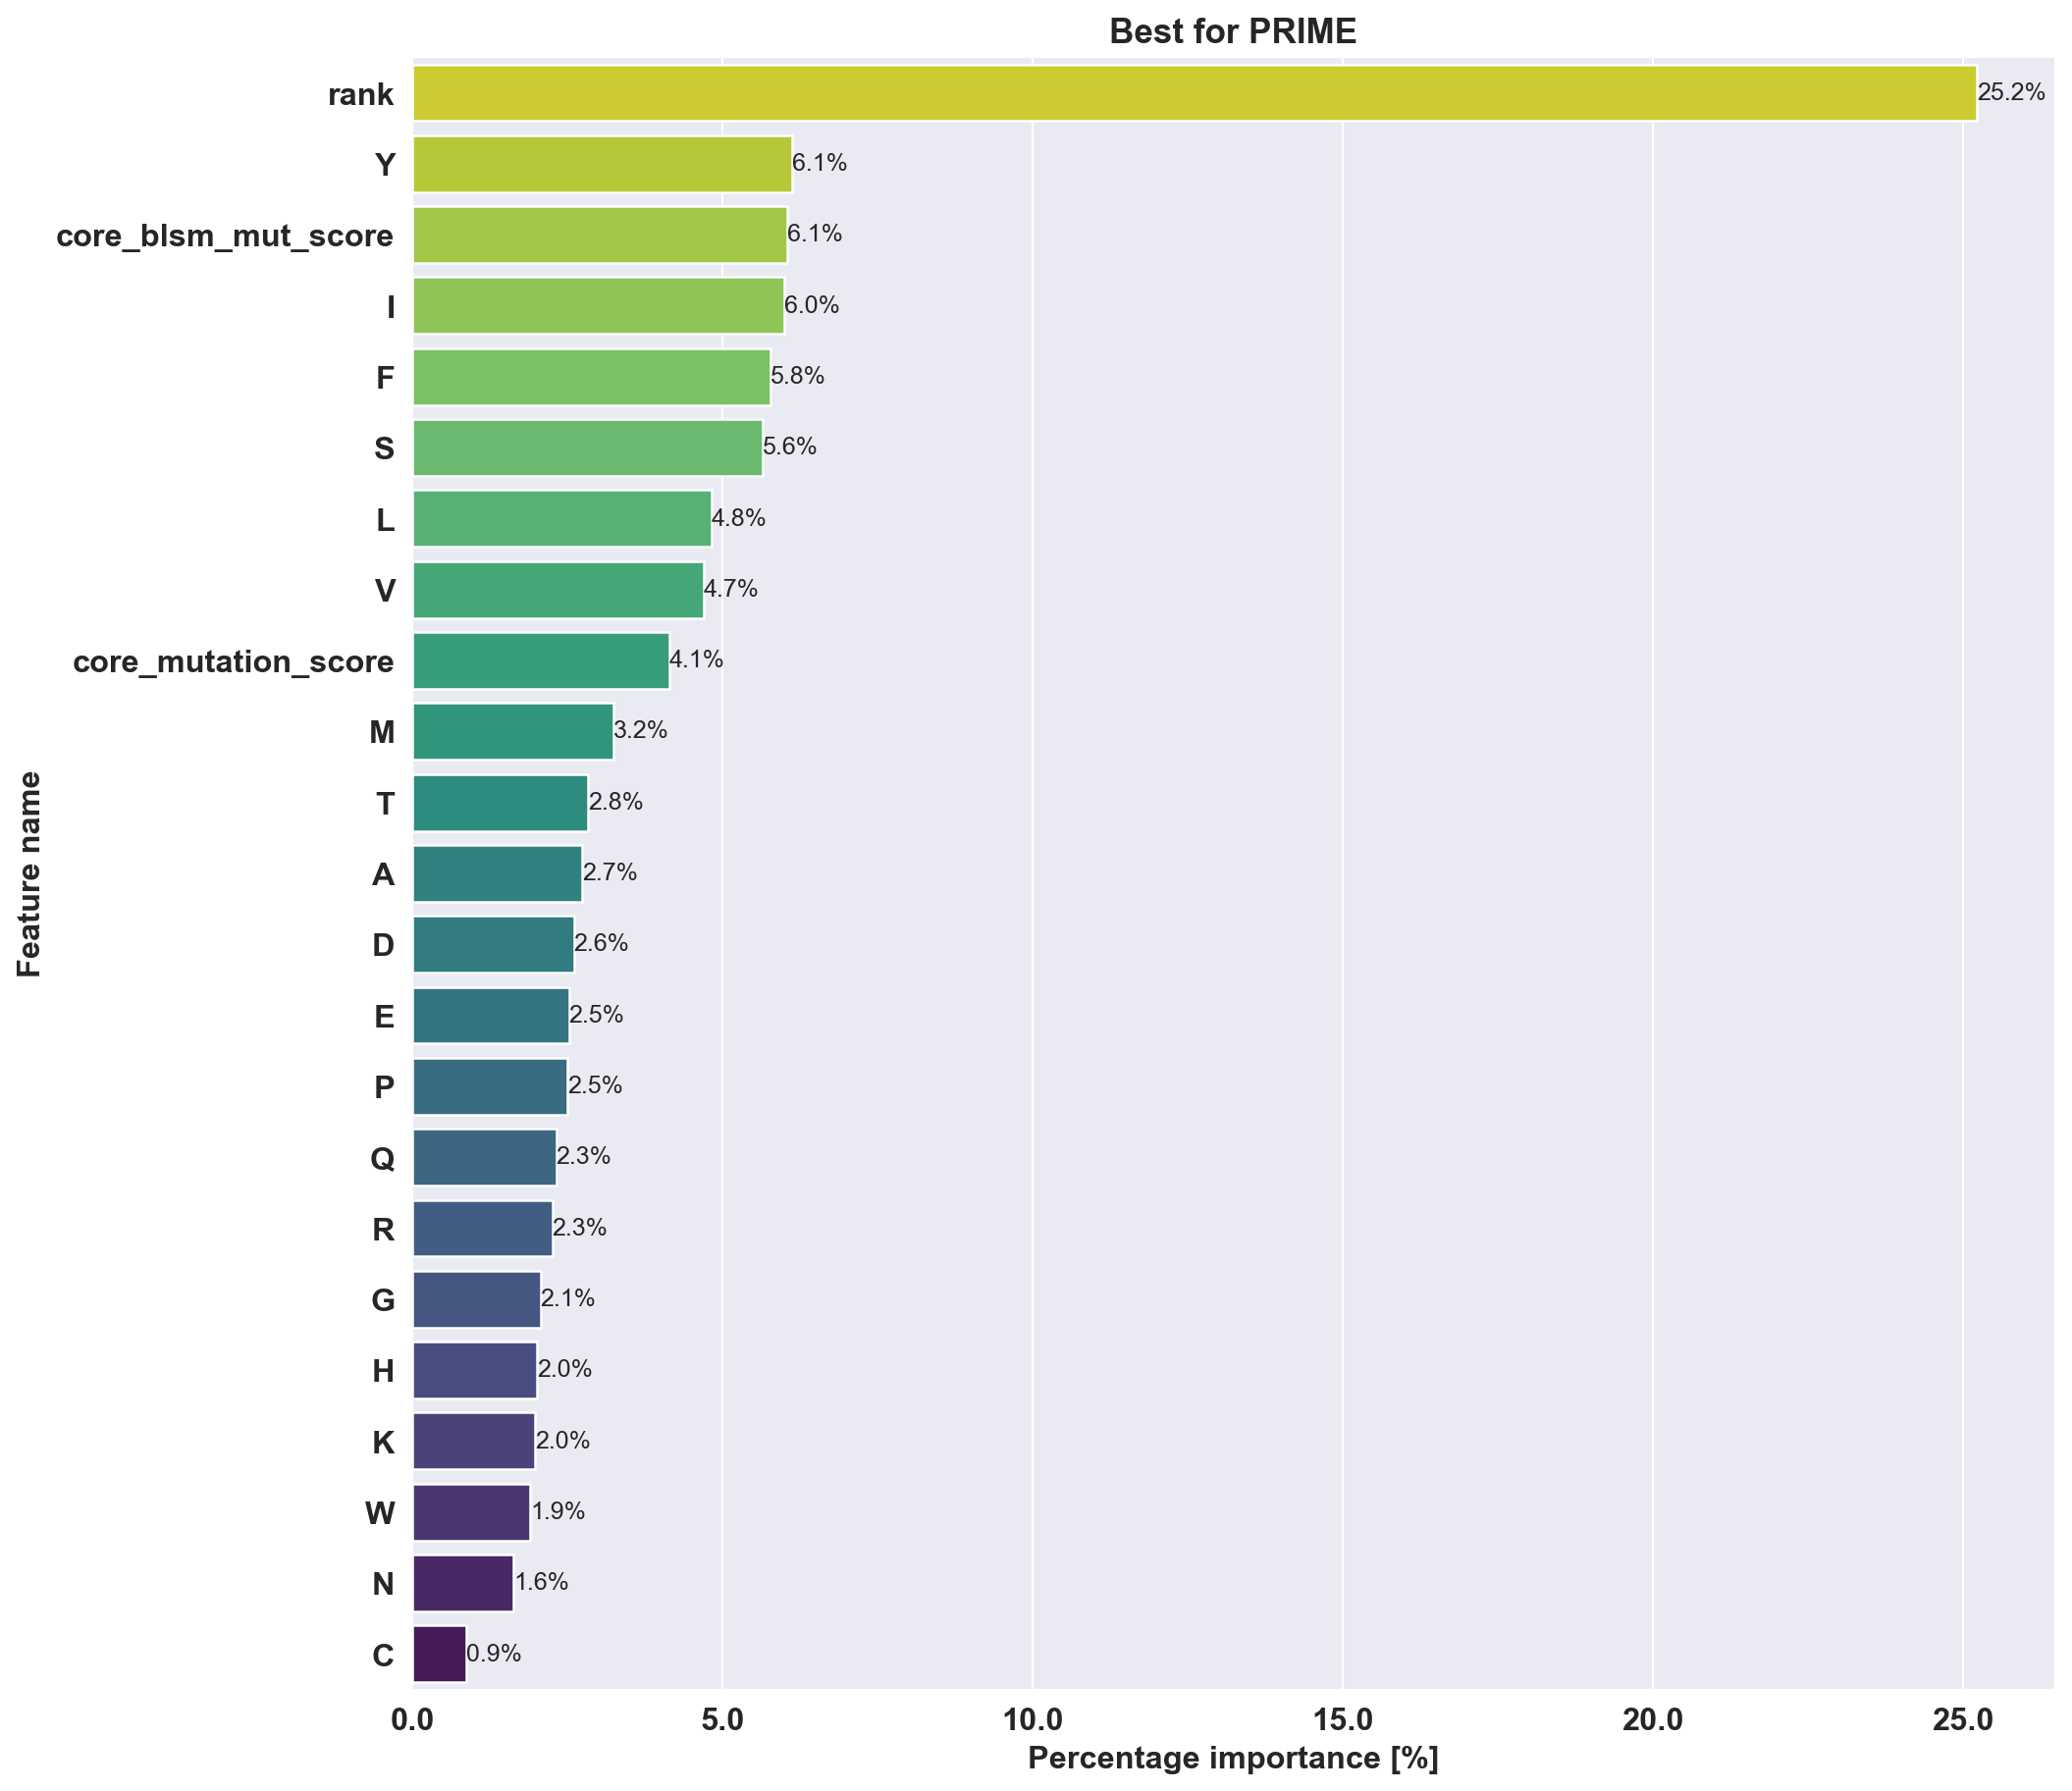

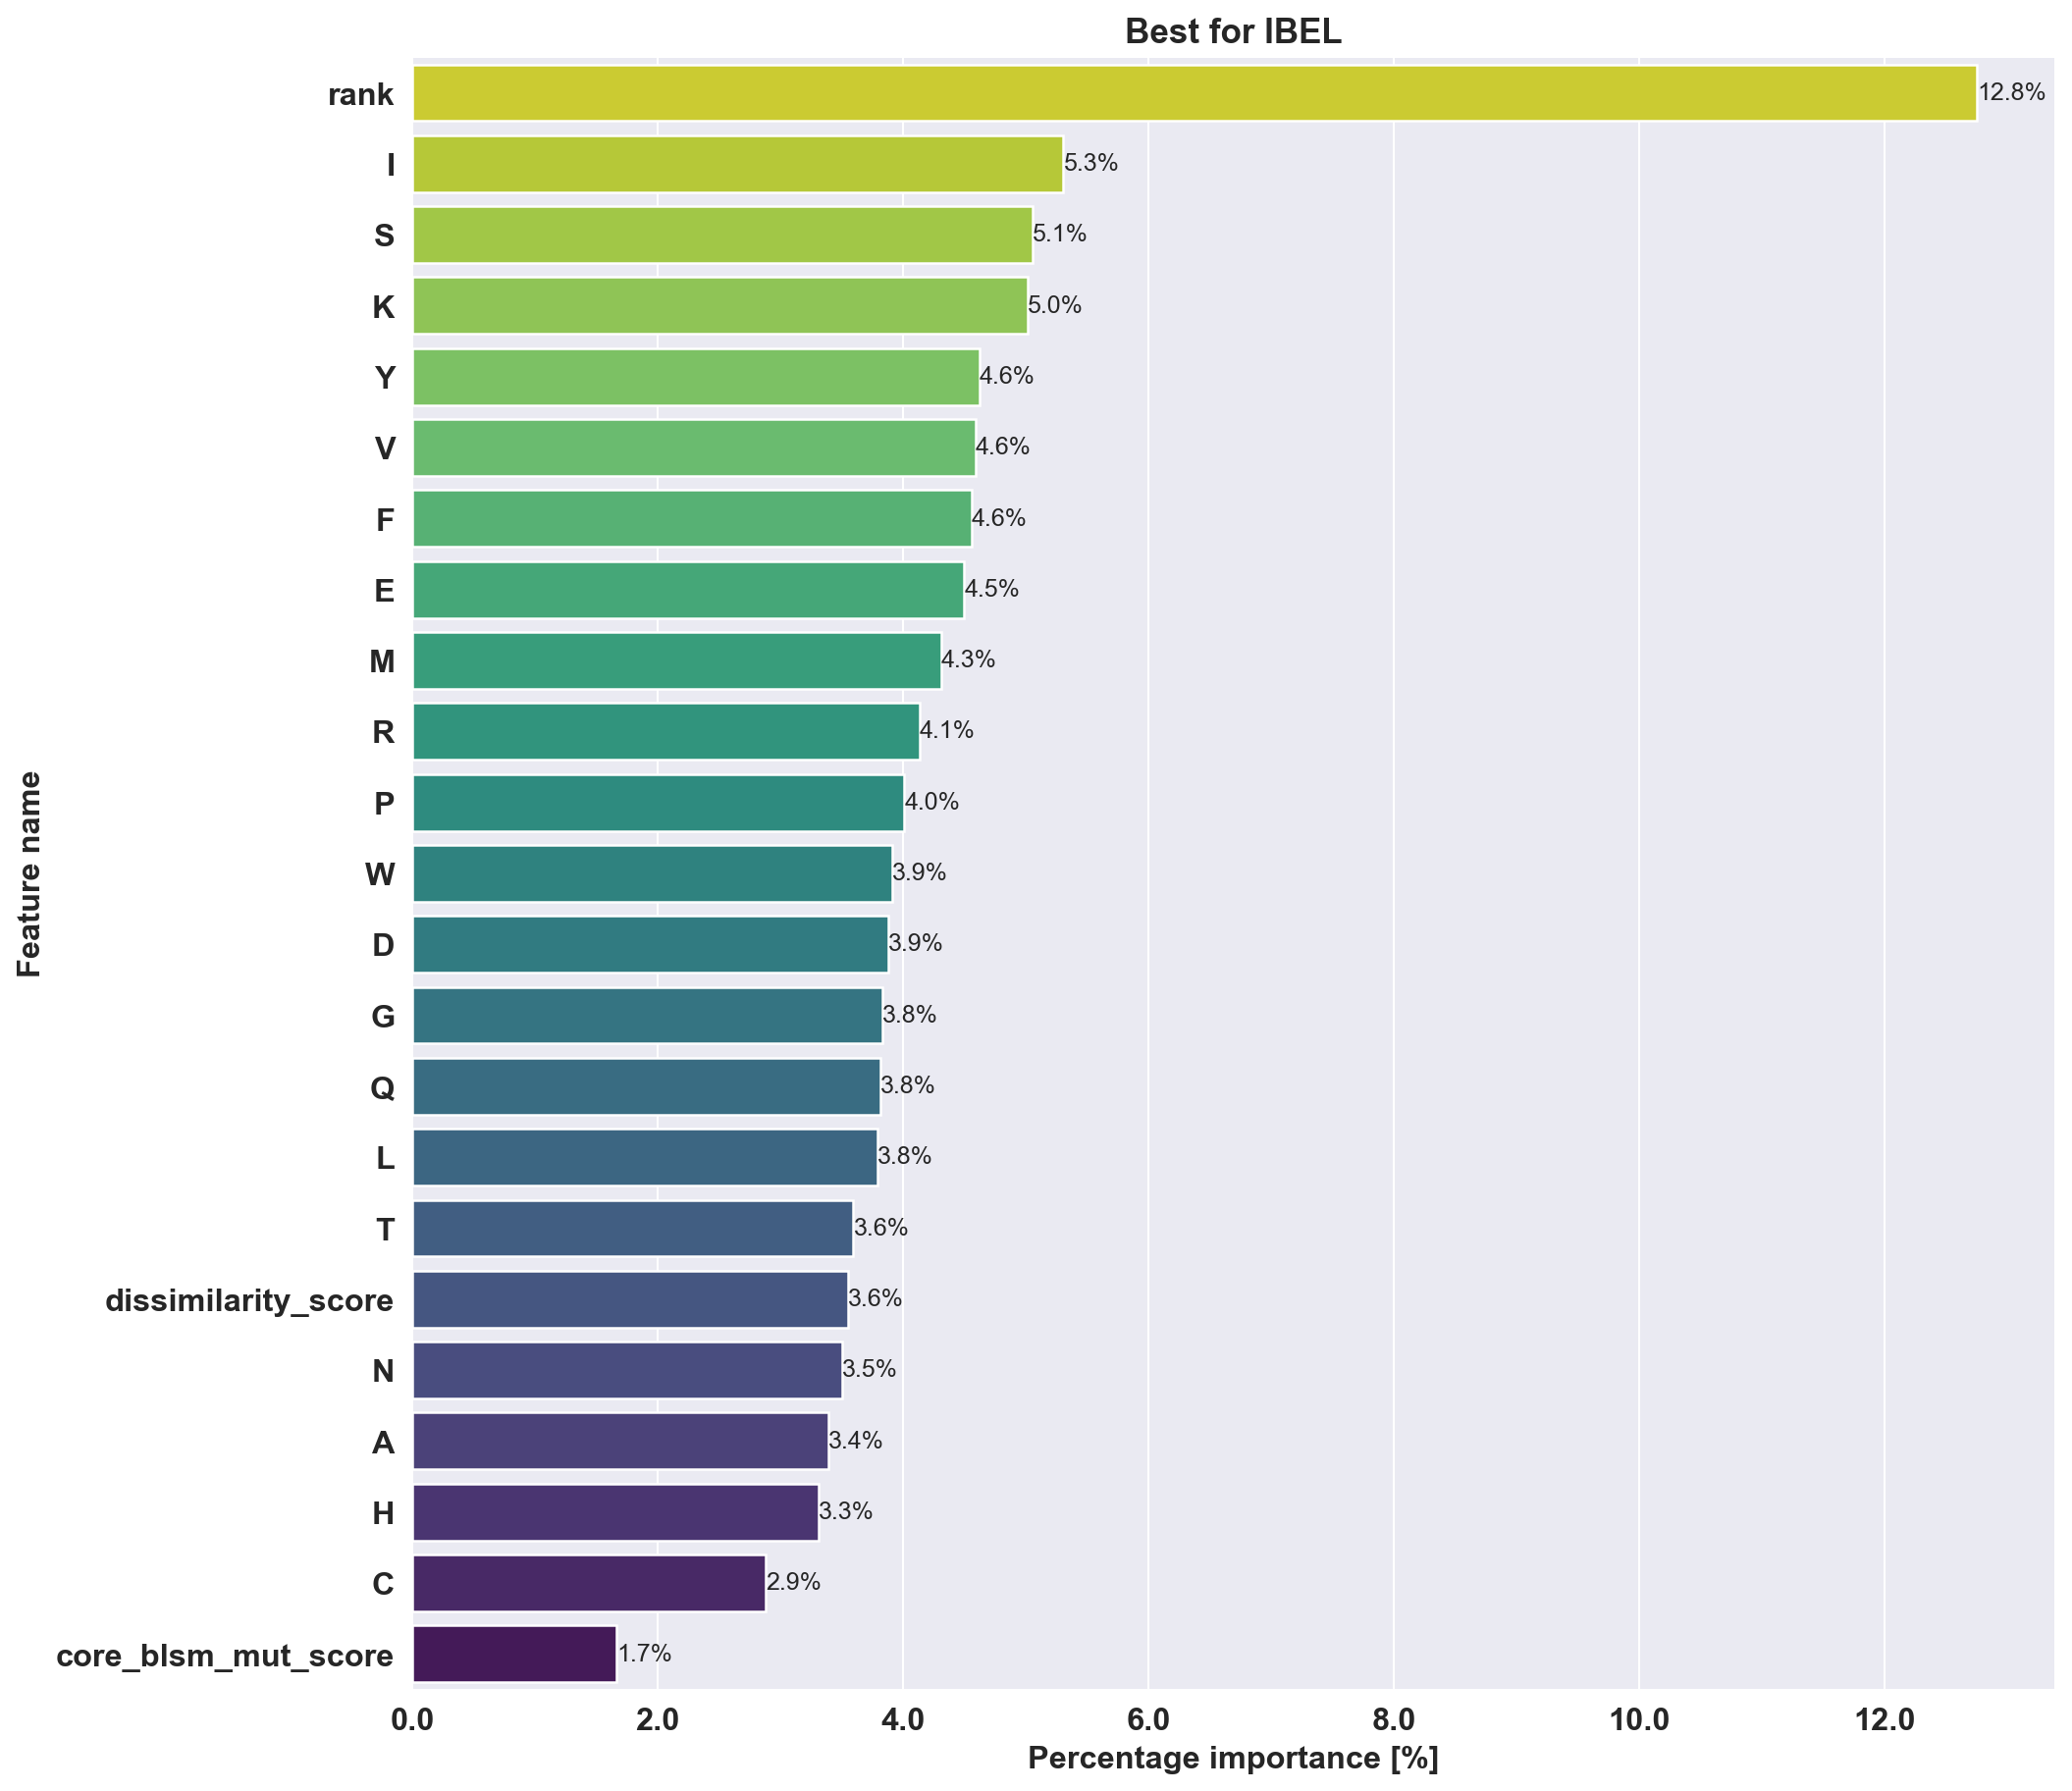

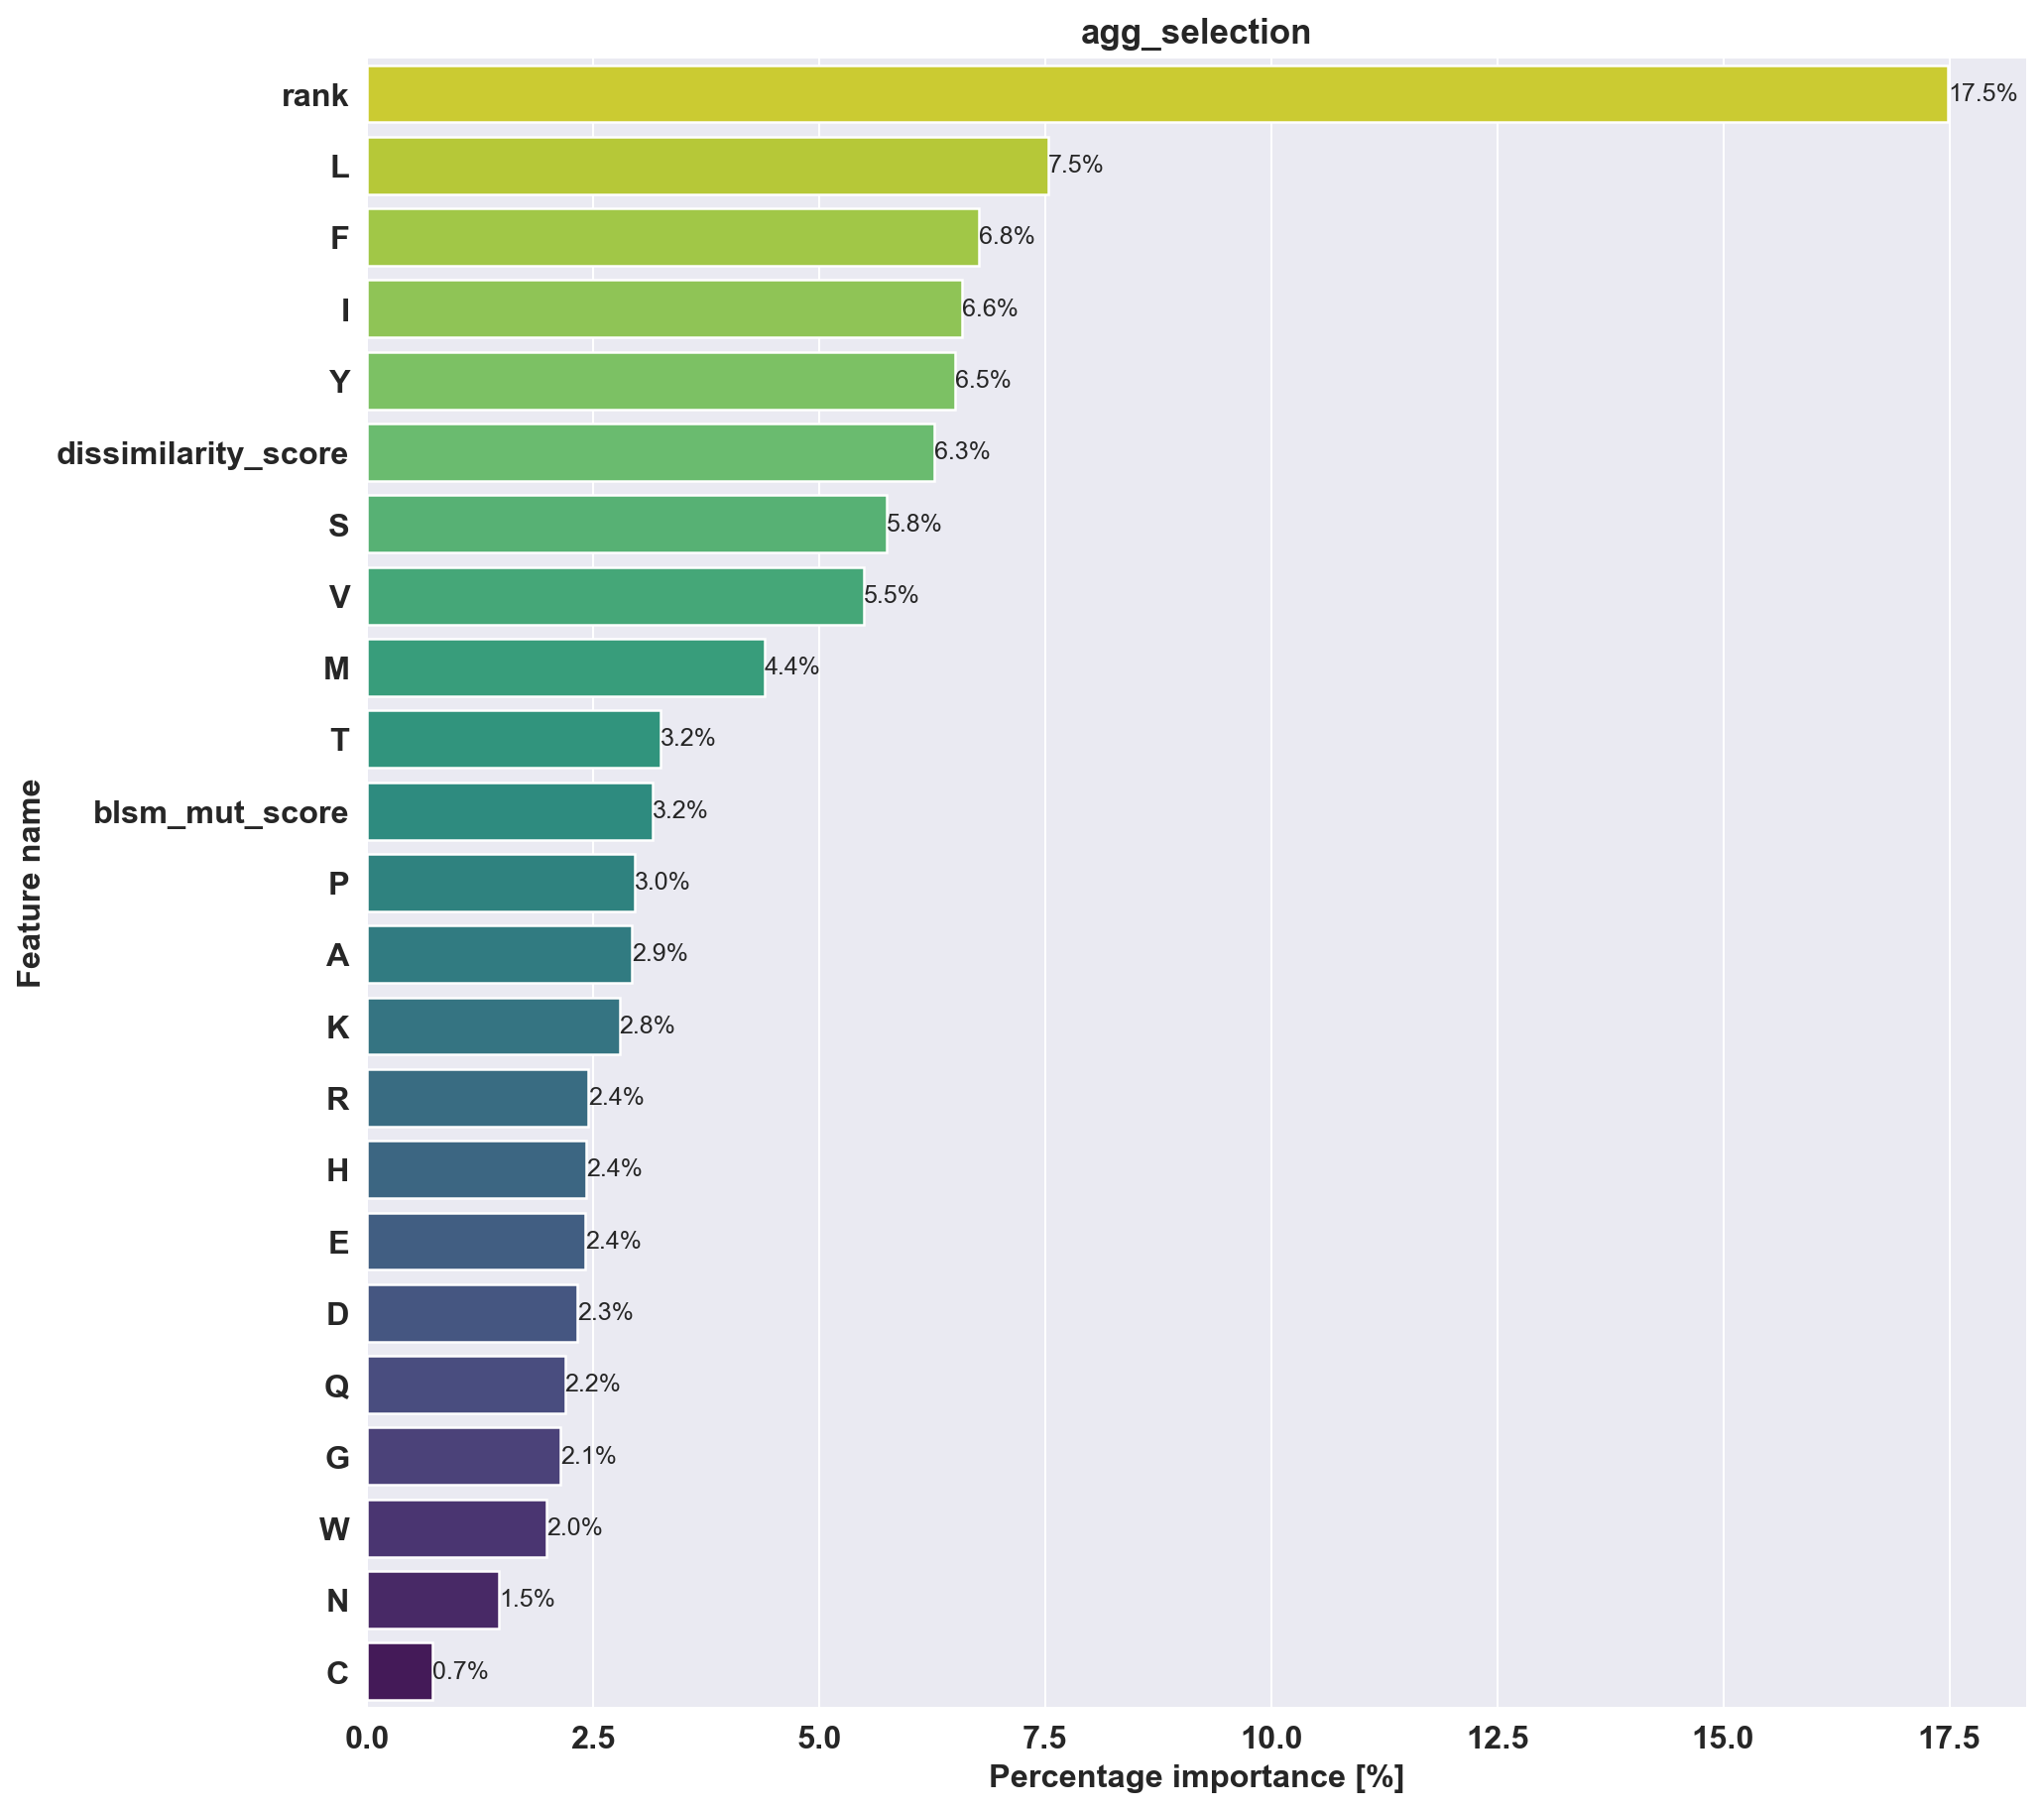

In [319]:
from src.metrics import plot_feature_importance
for k in best_models:
    f,a = plt.subplots(1,1, figsize=(12,12))
    fis = get_fi(**best_models[k]['cdt'])
    plot_feature_importance(fis.squeeze().values, fis.columns, title = k, label_number=True, ax=a)
    a.set_xticklabels(a.get_xticklabels(), fontweight='semibold', fontsize=13)
    a.set_yticklabels(a.get_yticklabels(), fontweight='semibold', fontsize=13)
    a.set_xlabel(a.get_xlabel(), fontweight='semibold', fontsize=13)
    a.set_ylabel(a.get_ylabel(), fontweight='semibold', fontsize=13)
    f.savefig(f"../../../meetings/slides/2301XX_CEDAR_meeting_update/featimps_{'_'.join(k.split(' '))}.png",
              bbox_inches='tight', dpi=200)

## Retrain models

In [104]:
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from src.data_processing import get_aa_properties, AA_KEYS
from sklearn.ensemble import RandomForestClassifier

cedar_trainset = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_evalset = pd.read_csv('../data/mutant/221117_prime_related_newcore_fold.csv')
ibel_evalset = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')

_, aa_cols = get_aa_properties(cedar_trainset.sample(1))
# Shannon for first 3
best_cedar = dict(max_len=12, encoding='onehot', blosum_matrix=None, mask = False, add_rank=True, invert=True,
                  add_aaprop=False, remove_pep=False, standardize=True, target_col = 'agg_label', seq_col ='icore_mut', 
                  rank_col='EL_rank_mut', hla_col ='HLA',
                  mut_col = aa_cols)

best_prime = dict(max_len=12, encoding='onehot', blosum_matrix=None, mask = True, add_rank=True, invert=False,
                  add_aaprop=False, remove_pep=False, standardize=True, target_col = 'agg_label', seq_col ='icore_mut', 
                  rank_col='EL_rank_mut', hla_col ='HLA', 
                  mut_col = ['core_blsm_mut_score', 'core_mutation_score'])

best_ibel = dict(max_len=12, encoding='blosum', blosum_matrix=BL62_VALUES, mask = True, add_rank=True, invert=False,
                  add_aaprop=False, remove_pep=False, standardize=True, target_col = 'agg_label', seq_col ='Peptide',
                 rank_col='trueHLA_EL_rank', hla_col ='HLA', 
                 mut_col = ['dissimilarity_score', 'core_blsm_mut_score'])
# KL for this one
best_agg = dict(max_len=12, encoding='onehot', blosum_matrix=None, mask = False, add_rank=True, invert=False,
                  add_aaprop=False, remove_pep=False, standardize=True, target_col = 'agg_label', seq_col ='icore_mut', 
                rank_col='EL_rank_mut', hla_col ='HLA', 
                mut_col = ['dissimilarity_score', 'blsm_mut_score'])

best_results = {}


for k, ics_dict, best_kwargs in zip(['Best for CEDAR', 'Best for PRIME', 'Best for IBEL', 'Compromise'],
                                   [ics_shannon, ics_shannon, ics_shannon, ics_kl],
                                   [best_cedar, best_prime, best_ibel, best_agg]):
    
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300, max_depth=8, ccp_alpha=9.945e-6)
    
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_trainset, model, ics_dict, best_kwargs, n_jobs=8)
    best_results[k] = {}
    best_results[k]['model'] = trained_models
    best_results[k]['kwargs'] = best_kwargs
    best_results[k]['ics_dict']= ics_dict
    fi = get_nested_feature_importance(trained_models)
    fn = AA_KEYS + ['%Rank'] + best_kwargs['mut_col']
    best_results[k]['featimp'] = pd.DataFrame(fi, index=fn).T
    
    for evalset, evalname in zip([cedar_trainset, prime_evalset, ibel_evalset], ['cedar', 'prime', 'ibel']):
        _, preds = evaluate_trained_models_sklearn(evalset, trained_models, ics_dict, cedar_trainset,
                                                   best_kwargs, concatenated=True, n_jobs=8)
        best_results[k][evalname] = preds
    

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

In [67]:
print(f"concat= {roc_auc_score(best_results['Compromise']['prime'].agg_label.values, best_results['Compromise']['prime'].pred.values)}")
mean = best_results['Compromise']['prime'].groupby(['Peptide', 'HLA', 'agg_label']).agg(mean_pred = ('pred','mean')).reset_index('agg_label')
print(f"mean = {roc_auc_score(mean['agg_label'].values, mean['mean_pred'].values)}")

concat= 0.6721917111154285
mean = 0.681924958080881


In [68]:
cedar_related[['Peptide', 'wild_type', 'HLA', 'agg_label']].to_csv('../../netmhcpan/test/data/cedar_test.pep',
                                                                   sep='\t', header=None, index=False)

In [283]:
from copy import deepcopy
best_nopreds = deepcopy(best_results)
for k in best_nopreds:
    del best_nopreds[k]['cedar'], best_nopreds[k]['prime'], best_nopreds[k]['ibel'], best_nopreds[k]['nepdb']

In [286]:
best_nopreds[k].keys()

dict_keys(['model', 'kwargs', 'ics_dict', 'featimp'])

In [285]:
pkl_dump(best_nopreds['Best for CEDAR'], './test.pkl')

./test.pkl saved.


# External dataset (NEPdb)

In [ ]:
def convert_hla(hla):
    if not hla.startswith('HLA-'):
        hla = 'HLA-'+hla
    return hla.replace('*','').replace(':','')

In [111]:
nepdb['Peptide'].to_csv('../../netmhcpan/nepdb.pep',index=False,header=False)

In [77]:
nepdb = pd.read_csv('/Users/riwa/Documents/code/NECID_Query.csv').query('antigen_type=="peptide"')
nepdb['HLA'] = nepdb.apply(lambda x : x['alleleA'] if x['locus']=='A' else x['alleleB'], axis=1)
nepdb['HLA'] = nepdb['HLA'].apply(convert_hla)
nepdb['agg_label']= nepdb.apply(lambda x: 1 if x['response']=='P' else 0, axis=1)
nepdb.head()

,fpkm,id,response,Tumor Type,genesymbol,genesymbol_ref,mut_aa_pos,wt_peptide,wt_aa,mut_dna,...,protein_sequence,TRAV,TRAJ,CDR3A,TRBV,TRBD,TRBJ,CDR3B,HLA,agg_label
4,NaN,7,N,Endometrial cancer,KRAS,KRAS,12.0,VVGAGGVGK,G,NaN,...,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HLA-A2402,0
5,NaN,20,N,Pancreatic cancer,KRAS,KRAS,12.0,KLVVVGAGGV,G,NaN,...,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HLA-A0101,0
6,NaN,21,P,Pancreatic cancer,KRAS,KRAS,12.0,VVGAGGVGK,G,NaN,...,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HLA-A1101,1
7,NaN,22,P,Endometrial cancer,KRAS,KRAS,12.0,VVGAGGVGK,G,NaN,...,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HLA-A1101,1
8,NaN,23,P,Pancreatic cancer,KRAS,KRAS,12.0,KLVVVGAGGV,G,NaN,...,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HLA-A0201,1


In [78]:
nepdb = nepdb.query('antigen_len<=12')[['mut_peptide', 'wt_peptide', 'HLA', 'agg_label']]
nepdb[['mut_peptide', 'wt_peptide', 'HLA', 'agg_label']]\
         .to_csv('../data/necid_query_filtered.csv', index=False, header=False, sep='\t')

## scores parsing 

In [83]:
df_nepdb = pd.read_csv('../output/test/necid_query_filtered.csv_full_df.csv')

In [87]:
from src.utils import pipeline_netmhcpan_xls, read_xls_parse_shift

nepdb_mut_xls = pipeline_netmhcpan_xls(df_nepdb, 
                                       '../../netmhcpan/score_shift/output/necid_query_filtered.csv_mut.fa.xls',
                                       xls_suffix= '_mut')
nepdb_wt_xls = pipeline_netmhcpan_xls(df_nepdb, 
                                      '../../netmhcpan/score_shift/output/necid_query_filtered.csv_wt.fa.xls',
                                      xls_suffix= '_wt')

common_cols = [x for x in nepdb_mut_xls.columns if x in nepdb_wt_xls.columns]
nepdb = pd.merge(nepdb_mut_xls, nepdb_wt_xls, 
                 left_on=common_cols, right_on=common_cols)

In [99]:
dissimilarity_scores = pd.read_csv('../../kern_dist/dist_out/necid_query_filtered.csv_mut_wt.pep_kerndist.out',
                                   header=None)
nepdb['dissimilarity_score'] = 1-dissimilarity_scores

In [89]:
from src.mutation_tools import check_wt, get_anchor, get_anchor_mutation, get_binder_type
from src.mutation_tools import get_mutation_pos, get_mutation_type, get_blsm_mutation_score, get_mutation_score
from src.data_processing import BL62, BL50

In [100]:
nepdb['len'] = nepdb['Peptide'].apply(len)
nepdb['mutation_type'] = 'substitution'#related_merged.apply(lambda x: get_mutation_type(x['Peptide'], x['wild_type']), axis=1)
nepdb['mhc_anchor'] = nepdb.apply(lambda x: get_anchor(x['HLA'].replace(':',''), ics_kl, threshold=.1615), axis=1)
nepdb['mutation_position'] = nepdb.apply(lambda x: get_mutation_pos(x['Peptide'], x['wild_type'], x['mutation_type']), axis=1)
nepdb['anchor_mutation'] = nepdb.apply(lambda x: get_anchor_mutation(x['Peptide'], x['wild_type'], 
                                                                                     x['core_mut'], x['core_wt'], 
                                                                                     x['len'], x['mhc_anchor'],
                                                                                     x['mutation_type']), axis=1)
nepdb['core_mutation_position'] = nepdb.apply(lambda x: get_mutation_pos(x['core_mut'], x['core_wt'], x['mutation_type']), axis=1)
nepdb['binder'] = nepdb.apply(lambda x: get_binder_type(x['EL_rank_mut'], x['EL_rank_wt']), axis=1)
nepdb['ratio_rank'] = nepdb['EL_rank_wt']/nepdb['EL_rank_mut']

nepdb['mutation_score'] = nepdb.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)
nepdb['blsm_mut_score'] = nepdb.apply(lambda x: get_blsm_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)

nepdb['core_mutation_score'] = nepdb.apply(lambda x: get_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)
nepdb['core_blsm_mut_score'] = nepdb.apply(lambda x: get_blsm_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)

In [102]:
nepdb, aa_cols = get_aa_properties(nepdb)

In [362]:
from src.utils import read_netmhcpan_results
nepdb_xls = read_netmhcpan_results('../../netmhcpan/score_full/output/nepdb.pep.xls')

In [363]:
nepdb_xls

base                       HLA-A0101                                \
     Pos     Peptide       ID       core       icore EL-score  EL_Rank   
0      0   AFGSAHLFR  PEPLIST  AFGSAHLFR   AFGSAHLFR   0.0005  29.3103   
1      0   AFGSAHLFR  PEPLIST  AFGSAHLFR   AFGSAHLFR   0.0005  29.3103   
2      0   AFGSAHLFR  PEPLIST  AFGSAHLFR   AFGSAHLFR   0.0005  29.3103   
3      0   AIANRIKFK  PEPLIST  AIANRIKFK   AIANRIKFK   0.0010  18.7128   
4      0   AICKPLHYV  PEPLIST  AICKPLHYV   AICKPLHYV   0.0024  11.1467   
..   ...         ...      ...        ...         ...      ...      ...   
324    0   YTSEHAASV  PEPLIST  YTSEHAASV   YTSEHAASV   0.0628   1.7228   
325    0   YVDVTYNFI  PEPLIST  YVDVTYNFI   YVDVTYNFI   0.1002   1.2849   
326    0  YVDVTYNFII  PEPLIST  YVDVTYNFI  YVDVTYNFII   0.0081   5.4720   
327    0   YVKLANLSY  PEPLIST  YVKLANLSY   YVKLANLSY   0.3324   0.4887   
328    0   YVVTISSLL  PEPLIST  YVVTISSLL   YVVTISSLL   0.0044   7.8305   

                       HLA-A0201  ... HLA-C1403           HLA-C1502  \
    BA-score  BA_Rank       core  ...  BA-score  BA_Rank       core   
0     0.0408  33.9135  AFGSAHLFR  ...    0.1600  11.9698  AFGSAHLFR   
1     0.0408  33.9135  AFGSAHLFR  ...    0.1600  11.9698  AFGSAHLFR   
2     0.0408  33.9135  AFGSAHLFR  ...    0.1600  11.9698  AFGSAHLFR   
3     0.0387  36.8067  AIANRIKFK  ...    0.0772  31.5388  AIANRIKFK   
4     0.0583  18.4564  AICKPLHYV  ...    0.1092  20.7678  AICKPLHYV   
..       ...      ...        ...  ...       ...      ...        ...   
324   0.2418   1.1481  YTSEHAASV  ...    0.4523   1.1571  YTSEHAASV   
325   0.4002   0.3432  YVDVTYNFI  ...    0.2937   3.7365  YVDVTYNFI   
326   0.3148   0.6574  YVDTYNFII  ...    0.1411  14.4918  YVDVTYNFI   
327   0.2800   0.8643  YVKLANLSY  ...    0.4829   0.9291  YVKLANLSY   
328   0.0984   6.8212  YVVTISSLL  ...    0.4775   0.9648  YVVTISSLL   

                                                        end      
          icore EL-score  EL_Rank BA-score  BA_Rank     Ave  NB  
0     AFGSAHLFR   0.0000  46.0000   0.0171  63.2536  0.0193   2  
1     AFGSAHLFR   0.0000  46.0000   0.0171  63.2536  0.0193   2  
2     AFGSAHLFR   0.0000  46.0000   0.0171  63.2536  0.0193   2  
3     AIANRIKFK   0.0008  17.4146   0.0460  30.4898  0.0666   7  
4     AICKPLHYV   0.2781   0.5464   0.3188   1.3035  0.1018  12  
..          ...      ...      ...      ...      ...     ...  ..  
324   YTSEHAASV   0.8506   0.0188   0.7058   0.0125  0.2251  30  
325   YVDVTYNFI   0.1583   0.9825   0.4154   0.5161  0.0745  17  
326  YVDVTYNFII   0.0019  12.5389   0.2695   2.1041  0.0033   1  
327   YVKLANLSY   0.0167   4.5699   0.1273   8.9128  0.1151  22  
328   YVVTISSLL   0.2732   0.5592   0.4477   0.3834  0.1130  24  

[329 rows x 383 columns]

In [114]:
nepdb_xls[('base','ID')] = nepdb['seq_id']

In [132]:
pd.read_csv('../../netmhcpan/score_shift/output/necid_query_filtered.csv_mut.fa.xls', sep='\t')


,Unnamed: 0,Unnamed: 1,Unnamed: 2,HLA-A0101,Unnamed: 4,Unnamed: 5,Unnamed: 6,HLA-A0201,Unnamed: 8,Unnamed: 9,...,HLA-C1403,Unnamed: 248,Unnamed: 249,Unnamed: 250,HLA-C1502,Unnamed: 252,Unnamed: 253,Unnamed: 254,Unnamed: 255,Unnamed: 256
0,Pos,Peptide,ID,core,icore,EL-score,EL_Rank,core,icore,EL-score,...,core,icore,EL-score,EL_Rank,core,icore,EL-score,EL_Rank,Ave,NB
1,0,AFGSAHLFR,seq_1,AFGSAHLFR,AFGSAHLFR,0.0005,29.3103,AFGSAHLFR,AFGSAHLFR,0.0001,...,AFGSAHLFR,AFGSAHLFR,0.0053,6.8293,AFGSAHLFR,AFGSAHLFR,0.0000,46.0000,0.0193,2
2,0,AFGSAHLF,seq_1,-AFGSAHLF,AFGSAHLF,0.0010,18.5000,AF-GSAHLF,AFGSAHLF,0.0001,...,AF-GSAHLF,AFGSAHLF,0.2704,0.5241,-AFGSAHLF,AFGSAHLF,0.0028,10.6471,0.0173,4
3,1,FGSAHLFR,seq_1,FGSAH-LFR,FGSAHLFR,0.0002,46.0000,FGS-AHLFR,FGSAHLFR,0.0000,...,FGS-AHLFR,FGSAHLFR,0.0002,24.5357,FGSAHLFR-,FGSAHLFR,0.0001,36.3750,0.0009,0
4,0,AFGSAHLFR,seq_2,AFGSAHLFR,AFGSAHLFR,0.0005,29.3103,AFGSAHLFR,AFGSAHLFR,0.0001,...,AFGSAHLFR,AFGSAHLFR,0.0053,6.8293,AFGSAHLFR,AFGSAHLFR,0.0000,46.0000,0.0193,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,0,YVKLANLS,seq_328,YVKLANLS-,YVKLANLS,0.0001,56.6000,YVKLANLS-,YVKLANLS,0.0000,...,YVKLANLS-,YVKLANLS,0.0001,37.2000,YVKLANLS-,YVKLANLS,0.0001,37.1429,0.0001,0
1352,1,VKLANLSY,seq_328,-VKLANLSY,VKLANLSY,0.0026,10.6506,VKL-ANLSY,VKLANLSY,0.0000,...,V-KLANLSY,VKLANLSY,0.0029,8.9822,-VKLANLSY,VKLANLSY,0.0000,43.7500,0.0024,0
1353,0,YVVTISSLL,seq_329,YVVTISSLL,YVVTISSLL,0.0044,7.8305,YVVTISSLL,YVVTISSLL,0.1246,...,YVVTISSLL,YVVTISSLL,0.0533,1.8632,YVVTISSLL,YVVTISSLL,0.2732,0.5592,0.1130,24
1354,0,YVVTISSL,seq_329,YVV-TISSL,YVVTISSL,0.0006,24.3043,YVV-TISSL,YVVTISSL,0.0093,...,-YVVTISSL,YVVTISSL,0.0754,1.4706,YVV-TISSL,YVVTISSL,0.0677,1.9983,0.0300,9


In [133]:

def parse_netmhcpan_full(row, netmhc_xls):
    hla = row['HLA'].replace(':', '')
    seq_id = row['seq_id']
    # print(hla, row)
    tmp = netmhc_xls.query('@netmhc_xls.base.ID==@seq_id')
    tmp = tmp[[x for x in tmp.columns if x[0] == hla or x[0] == 'base']]
    return tmp[(hla, 'EL_Rank')].item()

#     try:
#         argmin = tmp.iloc[tmp[(hla, 'EL_Rank')]
#     except:
#         print(tmp, hla)
#         raise Exception
#     try:
#         return argmin.drop(['EL-score', 'ID'])

#     except:
#         print('here')
#         return argmin['Pos'], argmin['Peptide'], argmin['core'], argmin['icore'], argmin['EL_Rank']


In [134]:
nepdb['trueHLA_EL_rank']=nepdb.apply(parse_netmhcpan_full, netmhc_xls=nepdb_xls,
                                     result_type='expand', axis=1)

## NepDB results

NepDB has some duplicated peps ; Need to see perf with and without filtering for those.
But technically those duplicates should be predicted the same
Diff in performance could be that those duplicated points are predicted wrong, and thus predicted wrong many times and lowers performance ; Best to look at perf without the duplicates and without concat

In [177]:
cedar_prime_peps = [x for x in cedar_related.Peptide.values if x in prime_related.Peptide.values]
nepdb.query('Peptide not in @cedar_prime_peps').drop_duplicates(subset=['Peptide', 'HLA'])

,Peptide,wild_type,HLA,agg_label,mut_len,wt_len,seq_id,Pos_mut,Peptide_mut,core_mut,...,core_blsm_mut_score,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8,trueHLA_EL_rank
0,AFGSAHLFR,AFGSAHLYR,HLA-A3101,1,9,9,seq_1,0,AFGSAHLFR,AFGSAHLFR,...,3,65.555556,0.837778,0.455556,10.551759,0.214444,-0.278889,0.193333,-0.192222,0.2470
3,AIANRIKFK,AIANRIKSK,HLA-A1101,0,9,9,seq_4,0,AIANRIKFK,AIANRIKFK,...,-2,108.888889,1.802222,-0.044444,11.823055,-0.048889,0.125556,0.484444,-0.125556,0.1380
4,AICKPLHYV,AICKPLHYM,HLA-A0201,0,9,9,seq_5,0,AICKPLHYV,AICKPLHYV,...,1,130.000000,-0.735556,0.755556,8.530526,0.327778,0.046667,-0.017778,0.263333,0.3610
5,AIPAMVVPNV,AIPAMVVPNA,HLA-A0201,0,10,10,seq_6,0,AIPAMVVPNV,AIPAVVPNV,...,0,146.000000,-1.637000,1.590000,6.100000,0.431000,-0.385000,-0.067000,0.446000,2.2606
6,ALEVLQSIPY,APEVLQSIPY,HLA-A0101,0,10,10,seq_7,0,ALEVLQSIPY,ALEVLQSIY,...,-3,156.000000,-0.472000,0.740000,3.849983,0.292000,-0.062000,-0.096000,0.088000,0.6230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,YTSEHAASV,YTPEHAASV,HLA-A0201,0,9,9,seq_325,0,YTSEHAASV,YTSEHAASV,...,-1,54.444444,1.480000,-0.277778,5.363446,-0.180000,-0.435556,-0.078889,-0.025556,0.2463
325,YVDVTYNFI,YVDVTYDFI,HLA-A0101,0,9,9,seq_326,0,YVDVTYNF,YVD-VTYNF,...,-14,107.777778,0.247778,0.600000,3.749987,0.338889,0.214444,-0.435556,-0.142222,1.2849
326,YVDVTYNFII,YVDVTYDFII,HLA-A0101,0,10,10,seq_327,0,YVDVTYNF,YVD-VTYNF,...,-14,136.000000,-0.269000,0.990000,3.749987,0.432000,0.223000,-0.408000,-0.141000,5.4720
327,YVKLANLSY,YVKLANLPY,HLA-A2601,0,9,9,seq_328,0,YVKLANLSY,YVKLANLSY,...,-1,130.000000,0.020000,0.311111,9.145600,0.224444,0.088889,0.008889,-0.372222,0.0914


In [184]:
# Filter out common peps + remove duplicates
nepdb = nepdb.query('Peptide not in @cedar_prime_peps').drop_duplicates(subset=['Peptide', 'HLA'])

In [180]:
print('#'*10, 'Removing the duplicates')
# Removing duplicates
for k,v in best_results.items():
    _, preds = evaluate_trained_models_sklearn(nepdb.drop_duplicates(subset=['Peptide', 'HLA', 'agg_label']), v['model'], v['ics_dict'],
                                               None, v['kwargs'], 
                                               concatenated=True, only_concat=True,
                                               n_jobs=8)
    best_results[k]['nepdb'] = preds
    col = 'pred' if 'pred' in preds.columns else 'mean_pred'
    auc = roc_auc_score(preds['agg_label'].values, preds[col].values)
    print(k, '\tNo filtering, concat', f'\t{auc:.1%}')
    
    
    _, preds = evaluate_trained_models_sklearn(nepdb.drop_duplicates(subset=['Peptide', 'HLA', 'agg_label']), v['model'], v['ics_dict'],
                                               cedar_related, v['kwargs'], 
                                               concatenated=True, only_concat=True,
                                               n_jobs=8)
    best_results[k]['nepdb'] = preds
    col = 'pred' if 'pred' in preds.columns else 'mean_pred'
    auc = roc_auc_score(preds['agg_label'].values, preds[col].values)
    print(k, '\tw/ filtering, concat', f'\t{auc:.1%}')
    _, preds = evaluate_trained_models_sklearn(nepdb.drop_duplicates(subset=['Peptide', 'HLA', 'agg_label']), v['model'], v['ics_dict'],
                                               None, v['kwargs'], 
                                               concatenated=False, only_concat=True,
                                               n_jobs=8)
    best_results[k]['nepdb'] = preds
    col = 'pred' if 'pred' in preds.columns else 'mean_pred'
    auc = roc_auc_score(preds['agg_label'].values, preds[col].values)
    print(k, '\tNo filtering, no concat', f'\t{auc:.1%}')
    
    
    _, preds = evaluate_trained_models_sklearn(nepdb.drop_duplicates(subset=['Peptide', 'HLA', 'agg_label']), v['model'], v['ics_dict'],
                                               cedar_related, v['kwargs'], 
                                               concatenated=False, only_concat=True,
                                               n_jobs=8)
    best_results[k]['nepdb'] = preds
    col = 'pred' if 'pred' in preds.columns else 'mean_pred'
    auc = roc_auc_score(preds['agg_label'].values, preds[col].values)
    print(k, '\tw/ filtering, no concat', f'\t{auc:.1%}')
print('#'*10, '\n')

########## Removing the duplicates


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Best for CEDAR 	No filtering, concat 	70.2%


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Best for CEDAR 	w/ filtering, concat 	66.3%


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Best for CEDAR 	No filtering, no concat 	70.7%


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Best for CEDAR 	w/ filtering, no concat 	63.6%


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Best for PRIME 	No filtering, concat 	68.9%


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Best for PRIME 	w/ filtering, concat 	70.9%


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Best for PRIME 	No filtering, no concat 	68.9%


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Best for PRIME 	w/ filtering, no concat 	61.8%


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Best for IBEL 	No filtering, concat 	68.1%


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Best for IBEL 	w/ filtering, concat 	66.7%


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Best for IBEL 	No filtering, no concat 	68.4%


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Best for IBEL 	w/ filtering, no concat 	62.9%


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Compromise 	No filtering, concat 	73.4%


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Compromise 	w/ filtering, concat 	74.7%


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Compromise 	No filtering, no concat 	73.6%


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Compromise 	w/ filtering, no concat 	65.0%
########## 



In [182]:
nepdb[['Peptide']].to_csv('../../gfeller_tools/PRIME-master/data/nepdb.pep', index=False, header=False)

In [335]:
nepdb_prime = pd.read_csv('../../gfeller_tools/PRIME-master/output/nepdb_prime.out',
                         comment = '#', sep ='\t')
nepdb_prime = nepdb_prime.merge(nepdb[['agg_label']], left_index=True, right_index=True).drop_duplicates(subset=['Peptide', 'BestAllele', 'agg_label'])
print(f"PRIME AUC: {roc_auc_score(nepdb_prime['agg_label'].values, nepdb_prime['Score_bestAllele'].values):.1%}")

PRIME AUC: 52.1%


In [299]:
nepdb.to_csv('../data/mutant/230124_nepdb_filtered_scored.csv', index=False)

# Ibel/Sine neoepitopes

In [301]:
ibel_sine = pd.read_csv('../data/neoepitopes_sine.csv', sep = '\t')
print(len(ibel_sine))
ibel_sine.head()

19541


,ID_pMHC,HLA_allele,Norm_peptide,Norm_MHCrank_EL,Mut_peptide,Core,Mut_MHCrank_EL,Mut_MHCrank_BA,HLA,Target,X.Rank_EL_mut,X.Rank_BA_mut,Aff.nM._mut,X.Rank_EL_wt,X.Rank_BA_wt,Aff.nM._wt,X.Rank_PRIME,Score_PRIME
0,BC-1849_A0101_YTDQISKYA,HLA-A01:01,YRDQISKYA,7.4062,YTDQISKYA,YTDQISKYA,0.2099,0.2605,A0101,1,0.304,0.209,322.83,12.023,21.239,27896.20,0.60,0.175676
1,BC-1849_A0101_QLEQLMQLY,HLA-A01:01,YLEQLHQLY,0.0224,QLEQLMQLY,QLEQLMQLY,0.0784,0.1517,A0101,1,0.072,0.169,242.38,0.019,0.028,29.83,0.02,0.201746
2,BC-1849_A0101_ILEYTDQISKY,HLA-A01:01,ILEYRDQISKY,0.2888,ILEYTDQISKY,ILEDQISKY,0.2636,0.6203,A0101,1,0.220,0.787,2109.11,0.244,0.994,2926.89,0.20,0.187296
3,BC-2389_A0101_CIDFQPDIY,HLA-A01:01,CIDFQPEIY,0.0699,CIDFQPDIY,CIDFQPDIY,0.0602,0.0279,A0101,1,0.071,0.022,25.66,0.059,0.031,32.51,0.03,0.199159
4,BC-2389_A0101_SCIDFQPDIY,HLA-A01:01,SCIDFQPEIY,0.1396,SCIDFQPDIY,SIDFQPDIY,0.1178,0.1741,A0101,1,0.150,0.157,216.17,0.140,0.213,331.18,3.00,0.165775


In [323]:
ibel_sine.rename(columns = {'Mut_peptide':'Peptide', 'Norm_peptide':'wild_type', 'Target':'agg_label'}, inplace=True)
ibel_sine['HLA'] = ibel_sine['HLA_allele'].str.replace(':','').str.replace('*','')
ibel_sine=ibel_sine.drop(index=ibel_sine.loc[ibel_sine['wild_type'].isna()].index).query('HLA in @HLAS')
ibel_sine.to_csv('../data/mutant/ibel_sine_neoepi_dataprep.csv',index=False, header=False,
                                                       columns = ['Peptide', 'wild_type', 'HLA', 'agg_label'], sep ='\t')
ibel_sine.to_csv('../data/mutant/ibel_sine_neoepi.csv',index=False)

In [321]:
roc_auc_score(ibel_sine['agg_label'].values, ibel_sine['Score_PRIME'].values)

0.6026953816324456

In [374]:
df_ibelsine= pd.read_csv('../output/data_prep/ibel_sine_neoepi_dataprep.csv_full_df.csv')
df_ibelsine

,Peptide,wild_type,HLA,agg_label,mut_len,wt_len,seq_id
0,AAAAAAAAA,AAAAAAAAA,HLA-B3501,0,9,9,seq_1
1,AAAAAAAAA,AAAAAAAAA,HLA-C0304,0,9,9,seq_2
2,AAAAAAAAL,AAAAAAAAS,HLA-A0205,0,9,9,seq_3
3,AAAAAAAAV,AAAAAAAAV,HLA-A0205,0,9,9,seq_4
4,AAAAAAAFSL,AAAAAAAFSS,HLA-C0304,0,10,10,seq_5
...,...,...,...,...,...,...,...
18347,YYYEYGEAE,YDYEYGEAE,HLA-C0702,0,9,9,seq_18348
18348,YYYEYGEAEY,YDYEYGEAEY,HLA-C0702,0,10,10,seq_18349
18349,YYYEYGEAEY,YDYEYGEAEY,HLA-A2402,0,10,10,seq_18350
18350,YYYHGHLQW,YYYHGHPQW,HLA-C0702,0,9,9,seq_18351


In [377]:
from src.utils import pipeline_netmhcpan_xls_shift
df_ibelsine = pipeline_netmhcpan_xls_shift(df_ibelsine, '../../netmhcpan/score_shift/output/ibel_sine_neoepi_dataprep.csv_mut.fa.xls', '_mut')

In [378]:
df_ibelsine

,Peptide,wild_type,HLA,agg_label,mut_len,wt_len,seq_id,Pos_mut,Peptide_mut,core_mut,icore_mut,EL_rank_mut
0,AAAAAAAAA,AAAAAAAAA,HLA-B3501,0,9,9,seq_1,0,AAAAAAAAA,AAAAAAAAA,AAAAAAAAA,6.4214
1,AAAAAAAAA,AAAAAAAAA,HLA-C0304,0,9,9,seq_2,0,AAAAAAAAA,AAAAAAAAA,AAAAAAAAA,4.4712
2,AAAAAAAAL,AAAAAAAAS,HLA-A0205,0,9,9,seq_3,0,AAAAAAAAL,AAAAAAAAL,AAAAAAAAL,1.2183
3,AAAAAAAAV,AAAAAAAAV,HLA-A0205,0,9,9,seq_4,0,AAAAAAAAV,AAAAAAAAV,AAAAAAAAV,0.9800
4,AAAAAAAFSL,AAAAAAAFSS,HLA-C0304,0,10,10,seq_5,1,AAAAAAFSL,AAAAAAFSL,AAAAAAFSL,0.1062
...,...,...,...,...,...,...,...,...,...,...,...,...
18347,YYYEYGEAE,YDYEYGEAE,HLA-C0702,0,9,9,seq_18348,0,YYYEYGEAE,YYYEYGEAE,YYYEYGEAE,2.1596
18348,YYYEYGEAEY,YDYEYGEAEY,HLA-C0702,0,10,10,seq_18349,0,YYYEYGEAEY,YYYEYGEEY,YYYEYGEAEY,0.0939
18349,YYYEYGEAEY,YDYEYGEAEY,HLA-A2402,0,10,10,seq_18350,0,YYYEYGEAEY,YYYEYGEEY,YYYEYGEAEY,0.6362
18350,YYYHGHLQW,YYYHGHPQW,HLA-C0702,0,9,9,seq_18351,0,YYYHGHLQW,YYYHGHLQW,YYYHGHLQW,0.0800


# Dataset investigation

## gene expr

Using TCGA-PanCan RNA expr set

In [195]:
cedar_related['wild_type'].to_csv('../../cedar_wt.txt', index=False, header=False)

In [287]:
cedar_wt_expr = pd.read_csv('../data/pepx/PepX_CEDAR_summary_tcgapancan.csv')
cedar_related.query('wild_type not in @cedar_wt_expr.Peptide.values')

,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,PMIDs,Peptide_mut,Peptide_wt,Pos_mut,...,wt_core,wt_true,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8
85,ALLGSSCAPPL,HLA-A0201,1.2142,0,4,7.4968,27198675,ALLGSSCAPPL,ALLGSSCAP,0,...,ALLGSSPPP,True,124.545455,-1.254545,1.118182,5.922540,0.314545,-0.713636,-0.027273,0.271818
94,ALQHFELENSL,HLA-A0201,0.3415,0,6,0.4922,27198675,ALQHFELENSL,ALQHFELANSL,0,...,ALFELANSL,True,115.454545,1.300909,-0.181818,4.254269,0.030909,0.000000,0.173636,-0.268182
148,APLPQQFHLKI,HLA-B0702,0.0915,0,9,0.0915,27198675,APLPQQFHL,APLPQQFHL,0,...,APLPQHLKT,True,115.454545,0.158182,-0.054545,9.702002,0.234545,0.096364,0.073636,0.457273
220,AVADMQVGAV,HLA-A0201,1.3756,0,0,2.3358,31511069,AVADMQVGAV,TVADMQVGAV,0,...,TVADMQVGV,True,117.000000,-0.658000,1.250000,3.749987,0.143000,-0.699000,0.134000,-0.340000
346,EEKLIVVLF,HLA-B4402,0.0361,0,3,0.0287,32314731,EEKLIVVLF,EEKLSVVLF,0,...,EEKLSVVLF,True,194.444444,-0.738889,1.377778,4.258147,0.388889,0.282222,0.182222,-0.162222
447,FIKSLPLVVKY,HLA-B1501,0.2332,0,2,0.8900,27198675,KSLPLVVKY,SLPLVVKY,2,...,FILPLVVKY,True,159.090909,-1.016364,1.072727,10.247608,0.440909,0.240000,-0.030909,0.161818
448,FILAERSSLF,HLA-B3501,1.7672,0,6,3.0794,27198675,ILAERSSLF,FILAERSSL,1,...,FILAERSSL,True,127.000000,0.600000,0.990000,6.410150,0.319000,0.079000,-0.137000,-0.118000
522,FLNVLFPLL,HLA-A0201,0.1949,1,4,0.2237,30418433,FLNVLFPLL,FLNVFFPLL,0,...,FLNVFFPLL,True,205.555556,-2.560000,2.211111,6.100000,0.941111,0.257778,-0.226667,-0.016667
566,FMLVQACRSV,HLA-A0201,1.7511,0,3,1.0596,31511069,MLVQACRSV,MLLQACRSV,1,...,FLLQACRSV,True,107.000000,0.244000,1.240000,8.549912,0.264000,-0.005000,-0.338000,-0.170000
725,GLLNSIWPL,HLA-A0201,0.0705,1,5,0.1185,"33257508,33257508,33257508,33257508",GLLNSIWPL,GLLNSTWPL,0,...,GLLNSTWPL,True,173.333333,-1.434444,0.966667,6.100000,0.578889,-0.155556,0.108889,-0.145556


In [206]:
len(cedar_wt_expr), len(cedar_related), len(cedar_wt_expr)-len(cedar_related), len(cedar_related.query('wild_type not in @cedar_wt_expr.Peptide.values')), len(cedar_wt_expr)-len(cedar_related.drop_duplicates(subset=['wild_type']))

(2853, 3033, -180, 44, -43)

In [324]:
# Seems like for some Peptides, there are multiple possible Gene and thus expression
cedar_wt_expr.query('Peptide=="ALALIELYNA"')

,Peptide,Gene ENSG ID,Gene Symbol,Proteins Encoded by Gene,Proteins Containing Peptide,Fraction of Matching Proteins,Mean Occurrences per Protein,Gene TPM,Peptide TPM,Scaled Peptide TPM
355,ALALIELYNA,ENSG00000168710,AHCYL1,3,3,1.000,1.0,43.58020,43.580,43.580
1663,ALALIELYNA,ENSG00000158467,AHCYL2,7,5,0.714,1.0,9.03109,9.031,6.448


In [331]:
sum_=cedar_wt_expr.groupby('Peptide')[['Gene TPM', 'Peptide TPM', 'Scaled Peptide TPM']].sum()
max_=cedar_wt_expr.groupby('Peptide')[['Gene TPM', 'Peptide TPM', 'Scaled Peptide TPM']].max()
max_.loc[(cedar_wt_expr.groupby('Peptide').count()>1).any(axis=1)]

,Gene TPM,Peptide TPM,Scaled Peptide TPM
Peptide,,,
AALHNPRPGPL,0.271007,0.271,0.271
ALALIELYNA,43.580200,43.580,43.580
ALLPVGAYEV,0.001000,0.001,0.001
ALNPRSGSL,0.650987,0.651,0.651
AMAGSPVFL,16.960400,16.960,16.960
...,...,...,...
YSSHRHPHVVY,0.181005,0.181,0.181
YTILTPMLNPI,0.011000,0.011,0.011
YTTDDIEFY,0.610981,0.611,0.470


In [359]:
cedar_expr_merged = cedar_related.merge(sum_.reset_index().rename(columns={'Peptide':'wild_type'}),
                                        left_on='wild_type', right_on='wild_type')
print('Gene TPM', roc_auc_score(cedar_expr_merged['agg_label'].values, cedar_expr_merged['Gene TPM'].values))
print('Peptide TPM', roc_auc_score(cedar_expr_merged['agg_label'].values, cedar_expr_merged['Peptide TPM'].values))
print('Scaled Peptide TPM', roc_auc_score(cedar_expr_merged['agg_label'].values, cedar_expr_merged['Scaled Peptide TPM'].values))

Gene TPM 0.548091991624785
Peptide TPM 0.547940640493554
Scaled Peptide TPM 0.5462452363419178


In [332]:
sum_.loc[(cedar_wt_expr.groupby('Peptide').count()>1).any(axis=1)]

,Gene TPM,Peptide TPM,Scaled Peptide TPM
Peptide,,,
AALHNPRPGPL,0.383009,0.383,0.383
ALALIELYNA,52.611290,52.611,50.028
ALLPVGAYEV,0.002000,0.002,0.001
ALNPRSGSL,1.874987,1.875,1.875
AMAGSPVFL,17.891430,17.891,17.390
...,...,...,...
YSSHRHPHVVY,0.333004,0.333,0.333
YTILTPMLNPI,0.014000,0.014,0.014
YTTDDIEFY,0.692982,0.693,0.532


In [293]:
cedar_wt_expr.groupby(['Peptide'])['Gene ENSG ID'].count()

Peptide
AAAAAAQQLQV    1
AAAAQQLQV      1
AAFDVGRITEV    1
AAHFTALLY      1
AAIAASRSA      1
              ..
YYLEGWRLL      1
YYSGKKEPF      1
YYSKNLNSS      1
YYSKNLNSSF     1
YYSPQAQTP      1
Name: Gene ENSG ID, Length: 2852, dtype: int64

In [288]:
cedar_related_expr = cedar_related.rename(columns = {'wild_type': 'merge'}).merge(cedar_wt_expr.rename(columns = {'Peptide': 'merge'}), 
                                                                                 left_on=['merge'], right_on=['merge'])
cedar_related_expr['Peptide'].to_csv('../../kern_dist/data/230124_cedar_related_expr.pep', index=False, header=False)

In [289]:
cedar_related_expr

,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,PMIDs,Peptide_mut,Peptide_wt,Pos_mut,...,VHSE8,Gene ENSG ID,Gene Symbol,Proteins Encoded by Gene,Proteins Containing Peptide,Fraction of Matching Proteins,Mean Occurrences per Protein,Gene TPM,Peptide TPM,Scaled Peptide TPM
0,AAAAAAQQIQV,HLA-B0702,3.9712,0,6,1.0441,27198675,AAAAAAQQI,AAAAAAQQL,0,...,-0.388182,ENSG00000126970,ZC4H2,3,2,0.667,1.0,4.41098,4.411,2.942
1,AAAAQQIQV,HLA-B0702,4.9092,0,6,4.7746,27198675,AAAAQQIQV,AAAAQQLQV,0,...,-0.367778,ENSG00000126970,ZC4H2,3,2,0.667,1.0,4.41098,4.411,2.942
2,AAAAQQIQV,HLA-A0201,1.9555,0,6,2.2847,27198675,AAAAQQIQV,AAAAQQLQV,0,...,-0.367778,ENSG00000126970,ZC4H2,3,2,0.667,1.0,4.41098,4.411,2.942
3,AAHFTVLLY,HLA-A1101,0.4196,0,9,0.5881,31511069,AAHFTVLLY,AAHFTALLY,0,...,-0.212222,ENSG00000149311,ATM,21,3,0.143,1.0,8.35072,8.351,1.194
4,AAIAASRSV,HLA-C1203,0.0591,0,6,1.1729,30556813,AAIAASRSV,AAIAASRSA,0,...,-0.114444,ENSG00000119280,C1orf198,5,1,0.200,1.0,20.89090,20.891,4.178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4218,YYNFEGDIALL,HLA-A2402,0.6247,0,9,0.7584,"34270940,34270940",YYNFEGDIALL,SYNFEGDIALL,0,...,-0.422727,ENSG00000159403,C1R,10,4,0.400,1.0,108.54900,108.549,43.420
4219,YYPGKKEPF,HLA-A2402,0.0965,0,1,0.0817,"34270940,34270940",YYPGKKEPF,YYSGKKEPF,0,...,0.535556,ENSG00000198804,MT-CO1,1,1,1.000,1.0,12671.50000,12671.500,12671.500
4220,YYSKNLNSF,HLA-A2402,0.0033,1,3,4.6860,28423700,YYSKNLNSF,YYSKNLNSS,0,...,-0.345556,ENSG00000146263,MMS22L,7,2,0.286,1.0,2.26106,2.261,0.647
4221,YYSKNLNSFF,HLA-A2402,0.0033,1,3,0.0350,"28423700,28423700",YYSKNLNSF,YYSKNLNSSF,0,...,-0.331000,ENSG00000146263,MMS22L,7,2,0.286,1.0,2.26106,2.261,0.647


In [211]:
from src.partition_tools import pipeline_stratified_kfold

cedar_related_expr = pipeline_stratified_kfold('../../kern_dist/out/230124_cedar_related_expr.pep_0.9.out',
                                               cedar_related_expr, k=10, elrank_col='EL_rank_mut')
cedar_related_expr.groupby(['fold', 'agg_label']).count()

start 2989
read hobohm 2357 698
strat kfold unique 2357 698
manually reassign identical 2357 698
manually reassign related 2357 698
concat 3055
merge 3055
drop duplicated 2989


Peptide  HLA  EL_rank_mut  EL_rank_wt  \
fold agg_label                                          
0    0              223  223          223         223   
     1               60   60           60          60   
1    0              231  231          231         231   
     1               74   74           74          74   
2    0              238  238          238         238   
     1               65   65           65          65   
3    0              253  253          253         253   
     1               64   64           64          64   
4    0              244  244          244         244   
     1               67   67           67          67   
5    0              223  223          223         223   
     1               57   57           57          57   
6    0              251  251          251         251   
     1               56   56           56          56   
7    0              235  235          235         235   
     1               66   66           66          66   
8    0              231  231          231         231   
     1               60   60           60          60   
9    0              236  236          236         236   
     1               55   55           55          55   

                Fraction of Proteins Containing Peptide (per Gene)  \
fold agg_label                                                       
0    0                                                        223    
     1                                                         60    
1    0                                                        231    
     1                                                         74    
2    0                                                        238    
     1                                                         65    
3    0                                                        253    
     1                                                         64    
4    0                                                        244    
     1                                                         67    
5    0                                                        223    
     1                                                         57    
6    0                                                        251    
     1                                                         56    
7    0                                                        235    
     1                                                         66    
8    0                                                        231    
     1                                                         60    
9    0                                                        236    
     1                                                         55    

                Gene ENSG IDs  Gene Mean Occurrences per Protein  \
fold agg_label                                                     
0    0                    223                                223   
     1                     60                                 60   
1    0                    231                                231   
     1                     74                                 74   
2    0                    238                                238   
     1                     65                                 65   
3    0                    253                                253   
     1                     64                                 64   
4    0                    244                                244   
     1                     67                                 67   
5    0                    223                                223   
     1                     57                                 57   
6    0                    251                                251   
     1                     56                                 56   
7    0                    235                                235   
     1                     66                                 66

In [213]:
cedar_related_expr.to_csv('../data/mutant/230124_cedar_related_expr.csv', index=False)
cedar_wt_expr.columns

Index(['Peptide', 'Gene Symbols', 'Total Peptide TPM', 'Median Peptide TPM',
       'Max Peptide TPM', 'Total Scaled Peptide TPM',
       'Median Scaled Peptide TPM', 'Max Scaled Peptide TPM', 'Total Gene TPM',
       'Median Gene TPM', 'Max Gene TPM', 'Gene ENSG IDs', 'Gene TPMs',
       'Peptide TPMs', 'Scaled Peptide TPMs', 'Proteins Encoded by Gene',
       'Proteins Containing Peptide (per Gene)',
       'Fraction of Proteins Containing Peptide (per Gene)',
       'Gene Mean Occurrences per Protein'],
      dtype='object')

In [ ]:
from scipy.stats import pearsonr, spearmanr, kendalltau
expr_desc = cedar_wt_expr[[x for x in cedar_wt_expr.columns if 'TPM' in x]].describe()
wrong_cols = []

data = [[], [], [], [], [], []]
cols_ = []
for col in [x for x in cedar_wt_expr.columns if 'TPM' in x]:
    try:
        pr = pearsonr(cedar_related_expr['agg_label'].values, cedar_related_expr[col].values)
        sr = spearmanr(cedar_related_expr['agg_label'].values, cedar_related_expr[col].values)
        kt = kendalltau(cedar_related_expr['agg_label'].values, cedar_related_expr[col].values)
        data[0].append(pr[0])
        data[1].append(pr[1])
        data[2].append(sr[0])
        data[3].append(sr[1])
        data[4].append(kt[0])
        data[5].append(kt[1])
        cols_.append(col)
        if pr[1]<=0.05 or sr[1]<=0.05 or kt[1]<=0.05:
            print(col)
            print(f'Pearson: \t{pr[0]:.3f},\t{pr[1]:.3e}')
            print(f'Spearman: \t{sr[0]:.3f},\t{sr[1]:.3e}')
            print(f'Kendall: \t{kt[0]:.3f},\t{kt[1]:.3e}')
    except:
        print(col)
        wrong_cols.append(col)
expr_desc = pd.concat([expr_desc, pd.DataFrame(data, columns = cols_, index=['PearsonCorr', 'PearsonP', 'SpearmanCorr', 'SpearmanP', 'KendallCorr', 'KendallP'])])
expr_desc

In [277]:
expr_desc.T.iloc[[expr_desc.T['PearsonP'].argmin()]].index, expr_desc.T.iloc[[expr_desc.T['SpearmanP'].argmin()]].index,  expr_desc.T.iloc[[expr_desc.T['KendallP'].argmin()]].index

(Index(['Max Gene TPM'], dtype='object'),
 Index(['Median Scaled Peptide TPM'], dtype='object'),
 Index(['Median Scaled Peptide TPM'], dtype='object'))

In [ ]:
expr_cols = ['Max Gene TPM', 'Median Scaled Peptide TPM']

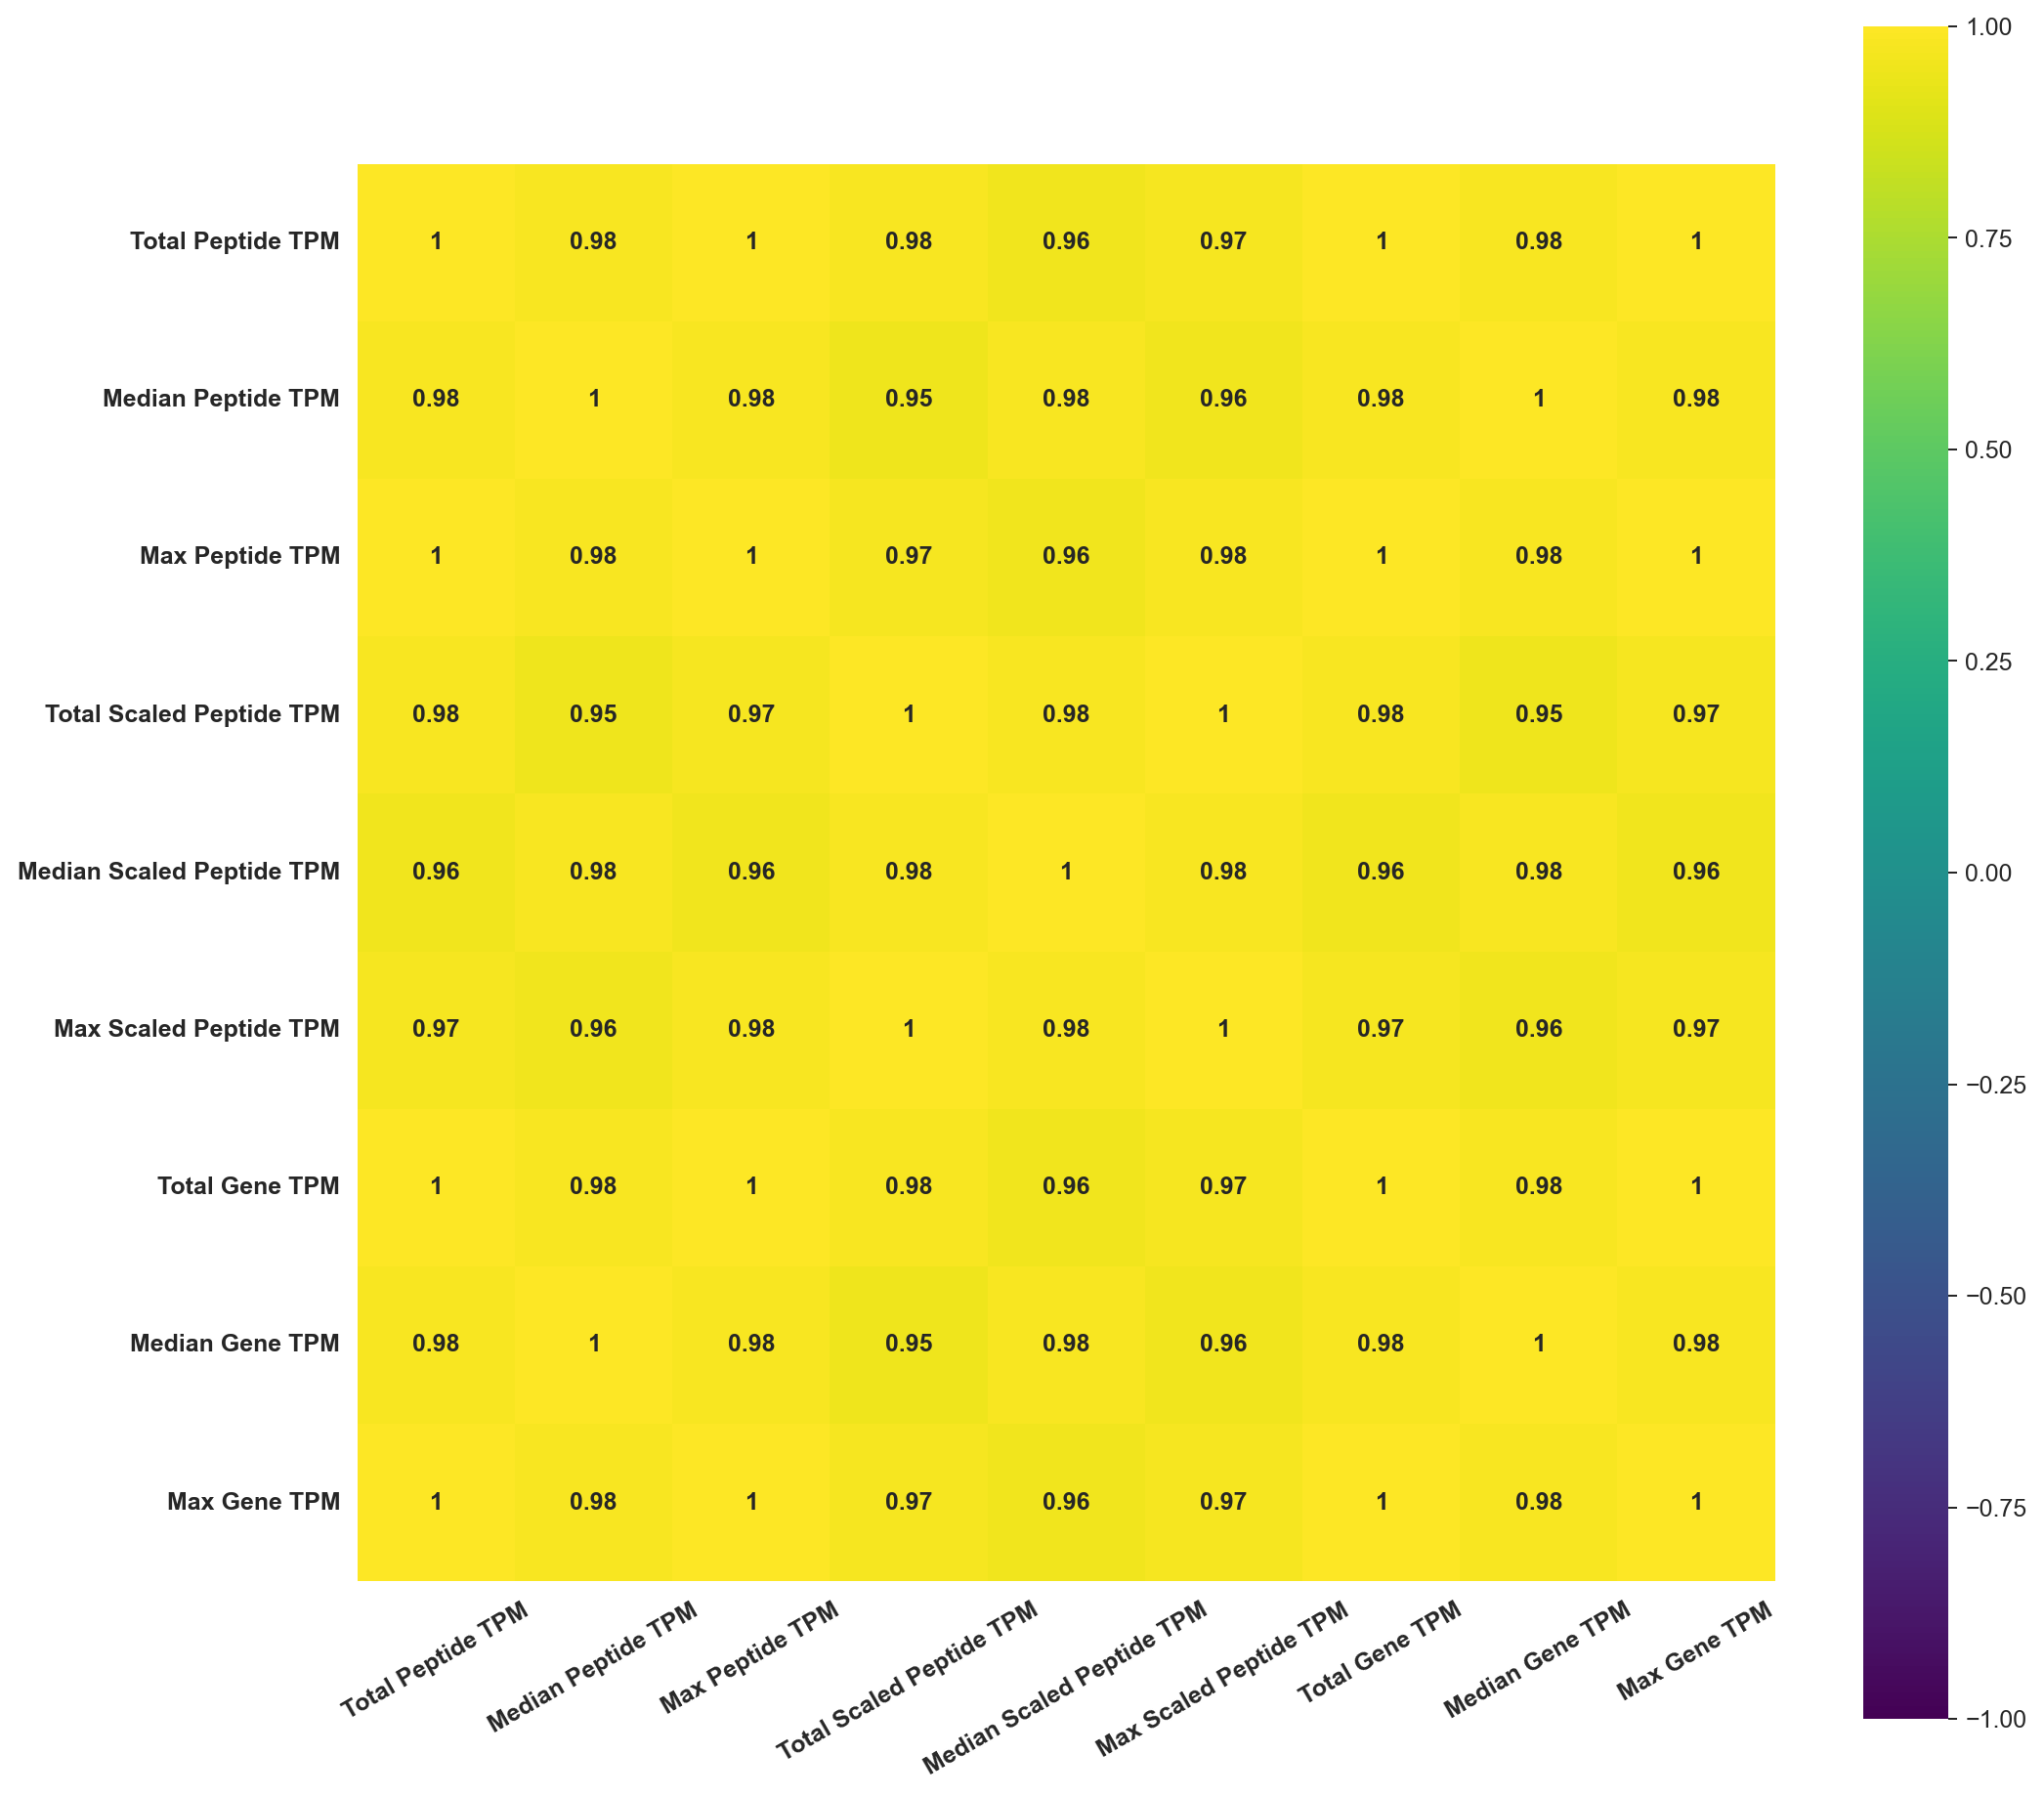

In [249]:
from src.utils import get_plot_corr
sns.set_palette('viridis')
get_plot_corr(cedar_wt_expr, cols=[x for x in cedar_wt_expr.columns if 'TPM' in x and x not in wrong_cols],
              which = 'spearman', palette='viridis')

In [280]:
# Save evalsets for mutscores expr
# Todo : PRIME, IBEL, NEPDB
prime_related.to_csv('../../prime_wt.txt', columns=['wild_type'], index=False,header=False)
ibel.to_csv('../../ibel_wt.txt', columns=['wild_type'], index=False,header=False)
nepdb.to_csv('../../nepdb_wt.txt', columns=['wild_type'], index=False,header=False)

## Check delta rank

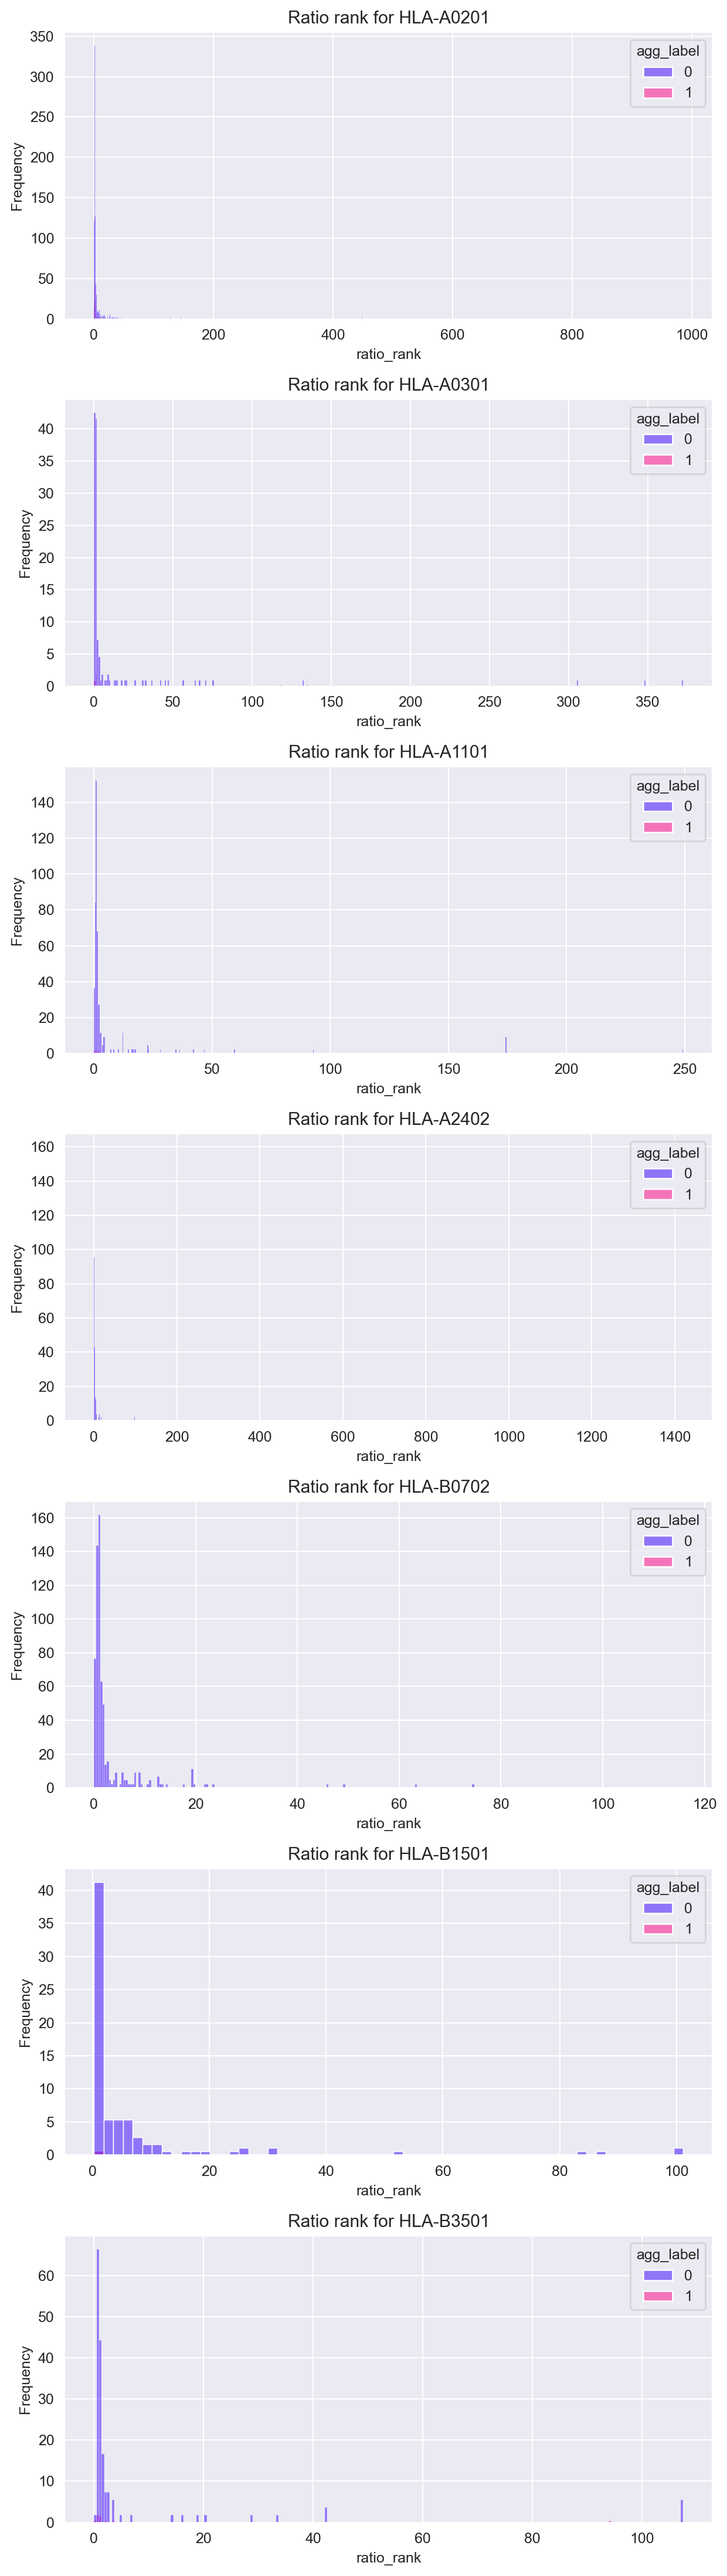

In [20]:
top_hlas = ['HLA-A0201', 'HLA-A0301', 'HLA-A1101', 'HLA-A2402', 'HLA-B0702', 'HLA-B1501', 'HLA-B3501']
cedar_related['ratio_rank'] = cedar_related['EL_rank_wt'] / cedar_related['EL_rank_mut']
f,a = plt.subplots(len(top_hlas), 1, figsize=(7, len(top_hlas)*3.5))
for hla, axis in zip(top_hlas, a.ravel()):
    tmp = cedar_related.query('HLA == @hla')
    sns.histplot(data=tmp, x='ratio_rank', hue = 'agg_label', ax = axis, stat='frequency')
    axis.set_title(f'Ratio rank for {hla}')
f.tight_layout()

In [192]:
top_hlas = ['HLA-A0201', 'HLA-A0301', 'HLA-A1101', 'HLA-A2402', 'HLA-B0702', 'HLA-B1501', 'HLA-B3501']
for hla in top_hlas:
    tmp = cedar_related.query('HLA == @hla')
    print(hla)
    display(tmp[['ratio_rank']].describe(percentiles=[.7,.8,.9]))


HLA-A0201


,ratio_rank
count,1168.000000
mean,11.224351
std,60.108729
min,0.037999
50%,1.440467
70%,2.512610
80%,4.137147
90%,11.130968
max,985.785714


HLA-A0301


,ratio_rank
count,159.000000
mean,15.687858
std,51.336830
min,0.065804
50%,1.297030
70%,2.002629
80%,5.825764
90%,34.471408
max,372.207792


HLA-A1101


,ratio_rank
count,252.000000
mean,7.839839
std,28.293576
min,0.104640
50%,1.233874
70%,1.940364
80%,2.772644
90%,12.485704
max,249.297872


HLA-A2402


,ratio_rank
count,294.000000
mean,23.456259
std,149.811684
min,0.173410
50%,1.169396
70%,1.815941
80%,3.274499
90%,10.578123
max,1420.000000


HLA-B0702


,ratio_rank
count,307.000000
mean,3.988937
std,10.291315
min,0.022756
50%,1.029412
70%,1.774889
80%,2.986143
90%,9.201419
max,115.804878


HLA-B1501


,ratio_rank
count,149.000000
mean,7.875049
std,17.490377
min,0.233264
50%,1.426374
70%,4.964153
80%,7.420419
90%,20.504161
max,101.145749


HLA-B3501


,ratio_rank
count,109.000000
mean,6.940823
std,20.487603
min,0.011832
50%,1.000000
70%,1.576070
80%,2.316760
90%,14.516488
max,107.537415


In [337]:
roc_auc_score(cedar_related['agg_label'].values, 1-cedar_related['trueHLA_EL_rank'].values)

0.6106196500275127

In [338]:
roc_auc_score(cedar_related['agg_label'].values, 1-cedar_related['EL_rank_mut'].values)

0.6337438690156512

In [341]:
cedar_related.query('icore_mut.str.contains("-")', engine='python')

,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,PMIDs,Peptide_mut,Peptide_wt,Pos_mut,...,wt_core,wt_true,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8


In [343]:
cedar_related['len']=cedar_related['Peptide'].apply(len)
cedar_related.query('len==8')

,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,PMIDs,Peptide_mut,Peptide_wt,Pos_mut,...,wt_core,wt_true,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8


In [347]:
best_results['Compromise']['kwargs']

{'max_len': 12,
 'encoding': 'onehot',
 'blosum_matrix': None,
 'mask': False,
 'add_rank': True,
 'invert': False,
 'add_aaprop': False,
 'remove_pep': False,
 'standardize': True,
 'target_col': 'agg_label',
 'seq_col': 'icore_mut',
 'rank_col': 'EL_rank_mut',
 'hla_col': 'HLA',
 'mut_col': ['dissimilarity_score', 'blsm_mut_score']}

In [353]:
cedar_related.query('icore_mut==icore_wt')[['agg_label', 'Peptide', 'wild_type', 'icore_mut', 'icore_wt', 'core_mut', 'core_wt']].groupby('agg_label').count()

,Peptide,wild_type,icore_mut,icore_wt,core_mut,core_wt
agg_label,,,,,,
0,94,94,94,94,94,94
1,9,9,9,9,9,9


## ibel sine

In [371]:
ibel_sine.columns

Index(['ID_pMHC', 'HLA_allele', 'wild_type', 'Norm_MHCrank_EL', 'Peptide',
       'Core', 'Mut_MHCrank_EL', 'Mut_MHCrank_BA', 'HLA', 'agg_label',
       'X.Rank_EL_mut', 'X.Rank_BA_mut', 'Aff.nM._mut', 'X.Rank_EL_wt',
       'X.Rank_BA_wt', 'Aff.nM._wt', 'X.Rank_PRIME', 'Score_PRIME'],
      dtype='object')

In [372]:
ibel_sine.Peptide.to_csv('../../netmhcpan/score_full/data/ibel_sine_neoepi_mut.pep')